__CoT Final Report__

### Import

In [1]:
import os
import sys
from datetime import datetime
import time
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import scipy.stats as scs

import sklearn as sk
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import RidgeCV,LassoCV, ElasticNetCV
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit, KFold, learning_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.svm import SVR


import statsmodels as smm
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from statsmodels.tsa.api import acf, pacf, graphics
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARMA

import pygam
from pygam import LinearGAM
from pygam import s,l,f,te

import warnings
import time
warnings.filterwarnings("ignore")



### Function Definition

In [57]:
def plotMissing(df,save=False,title='Missing Values'):
    #Missing value plot
    plt.figure(figsize=(8,6))
    sns.heatmap(df.isnull(),cbar=False)
    #sns.heatmap(df.iloc[np.unique(np.where(df.isnull())[0]),:].isnull(),cbar=False)
    plt.title('Missing Value')
    plt.tight_layout()
    if save:
        plt.savefig(title,dpi=300)
    plt.show()

def tsplot1(y, lags=None, figsize = (11,8), style = 'bmh',title = None):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2,3)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan = 3) 
        acf_ax = plt.subplot2grid(layout, (1,1))
        qq_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,2))
        y.plot(ax = ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags = lags, ax=acf_ax, alpha = 0.05) #autocorrelations, alpha is the hypothesis testing error bars.
        sm.qqplot(y, line = 's', ax=qq_ax)
        plot_pacf(y, lags = lags,alpha = .05, ax =pacf_ax )
        qq_ax.set_title('QQ PLot')
        plt.tight_layout() #keep into tight configuration. 
    return


def compareplot(y,y_pred,figsize):
    fig = plt.figure(figsize = (8,6))
    plt.plot(y_pred, label = "Forecast")
    plt.plot(y, label = "AM_N_Pos")
    plt.tight_layout()
    plt.legend()

def scorecard(method,err,y,pos_diff):
    global pos_score
    global diff_score
    mse=np.round(np.mean(err**2)/10000,3)
    mae=np.round(np.mean(np.abs(err)),3)
    ape=np.round(np.mean(np.abs((err)/y)),3)
    
    if pos_diff == 'dif':
        diff_score['MSE'][method] = mse
        diff_score['MAE'][method] = mae
        diff_score['APE'][method] = ape   

    if pos_diff == 'pos':
        pos_score['MSE'][method] = mse
        pos_score['MAE'][method] = mae
        pos_score['APE'][method] = ape   
    
    print("Model:",method)
    print('MSE is {0:.2f}'.format(mse))
    print('MAE is {0:.2f}'.format(mae))
    print('APE is {0:.2f}'.format(ape))

def evaluate(method, y, y_pred, pos_diff,lags = None, figsize = (13,14), style = 'bmh'):
    sns.set(font_scale = 1)
    err = y_pred - y
    scorecard(method,err,y,pos_diff)
    #compareplot(y,y_pred,figsize)
    if not isinstance(err,pd.Series):
        err = pd.Series(err)
    if not isinstance(y,pd.Series):
        y = pd.Series(y)
    if not isinstance(y_pred,pd.Series):
        y_pred = pd.Series(y_pred)
    
    with plt.style.context(style):
        fig = plt.figure(figsize = figsize)
        layout = (3,3)
        pr_ax = plt.subplot2grid(layout, (0,0),colspan = 3)
        ts_ax = plt.subplot2grid(layout, (1,0),colspan = 3)
        ft_ax = plt.subplot2grid(layout, (2,2))
        qq_ax = plt.subplot2grid(layout,(2,0))
        acf_ax = plt.subplot2grid(layout,(2,1))
        
        pr_ax.set_title(method +' Forecast vs AM Net Position')
        y.plot(ax = pr_ax, label ="AM Net Pos", color = "tab:blue")
        y_pred.plot(ax = pr_ax, label ="Forecast", color = "tab:orange", alpha = .7)
        pr_ax.legend(loc = 0, fontsize = 'large')
        
        ts_ax.set_title('Residuals Plot')
        err.plot(ax = ts_ax)
        
        acf_ax.set_title('Error ACF')
        smt.graphics.plot_acf(err,lags = lags, ax = acf_ax, alpha = .05)
        
        ft_ax.set_title('Actual vs Pred')
        ft_ax.plot([0, 1], [0, 1], transform=ft_ax.transAxes, ls="--", c="red")
        #ft_ax.set(xlim = (-50000,60000),)
        sns.scatterplot(y_pred,y,ax = ft_ax)
        
        qq_ax.set_title('QQ Plot')
        sm.qqplot(err,line = 's',ax = qq_ax)
        plt.tight_layout()
    return

def ErrorTest(y, y_pred):
    print(acorr_ljungbox(y - y_pred, lags = 10, return_df = True)[:3],"\n")
    res = sm.tsa.arma_order_select_ic(y - y_pred, ic=['aic', 'bic'], trend = 'nc')
    print("AIC Order Select:",res.aic_min_order)
    print("BIC Order Select:",res.bic_min_order)

#Correlation: Compute the correlation matrix
def plotCorr(labeled,save=False):
    s=10
    corr = labeled.iloc[:,:-1].corr()

    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True

    #sns.set_theme(style="white")
    f, ax = plt.subplots(figsize=(16, 16))
    ax = sns.heatmap(corr, square=True,linewidths=.4,annot=True,annot_kws={"size":8},fmt='.1f',cbar_kws={"shrink": .4}, mask=mask, cmap="coolwarm")
    # Draw the heatmap with the mask and correct aspect ratio
    plt.tight_layout()
    plt.title('Correlation Matrix',size=s)
    if save:
        plt.savefig('Correlation Matrix',dpi=300)
    plt.show()

#Test to ensure rolling window logic functions correctly
def Rebal_Dates(data, est = 123, wind = 5):
    periods = data.shape[0]
    rebal_count = (periods-est)//wind
    #print(periods)
    #print(est)
    #print(wind)
    #print(rebal_count)
    rebal_dates = []
    for i in range (0,rebal_count):
        #print("Rebal #:",i+1)
        #print("ESTIMATION________________")
        full = df_preCOV.iloc[i*wind:est+i*wind+wind,:].index
        #print("Starts :",full[0])
        #print("Stops  :",full[-1])
        train = full[:est]
        #print("TRAIN____________________")
        #print("Starts :",train[0])
        #print("Stops  :",train[-1])
        test = full[ est : est+ wind]
        #print("TEST____________________")
        rebal_dates.append(test[0])
        #print("Starts :",test[0])
        #print("Stops  :",test[-1])
        #print("\n")
    count = len(rebal_dates)
    return rebal_dates, count

def Lasso(X_train_std, X_test_std, y_train): 
    lasso = LassoCV(max_iter = 10000, alphas = np.logspace(.1,3,100))
    lasso.fit(X_train_std, y_train)
    forecast = lasso.predict(X_test_std)
    coef = lasso.coef_
    alpha = lasso.alpha_      
    return  coef, alpha, forecast

def Ridge(X_train_std, X_test_std, y_train): 
    ridge = RidgeCV(alphas = np.linspace(0.1,1,100))
    ridge.fit(X_train_std, y_train)
    forecast = ridge.predict(X_test_std)
    coef = ridge.coef_
    alpha = ridge.alpha_ 
    return coef, alpha, forecast

def RF(X_train_std, X_test_std, X_train, y_train,tscv):  
    rf2 = RandomForestRegressor(n_estimators = 30, max_depth = 6, max_features = 'sqrt')
    p = X_train_std.shape[1]
    param_grids_random = {
    'max_depth': [2, 3, 5, 6, 8, 10],
    'n_estimators': [2, 5, 10, 15, 20, 25, 30, 50, 100]
    }
    random_grid_search = RandomizedSearchCV(estimator = rf2,param_distributions = param_grids_random,\
                                            scoring='neg_mean_absolute_error',cv=tscv, n_iter = 20)\
                                            .fit(X_train_std, y_train)
    params = list(random_grid_search.best_params_.values())
    n_est, mxdpth = params[0],params[1]
    rf2 = RandomForestRegressor(n_estimators = n_est, max_depth = mxdpth, max_features = 'sqrt')
    X_train_std_df = pd.DataFrame(X_train_std, columns = X_train.columns)
    rf2.fit(X_train_std_df, y_train)
    forecast = rf2.predict(X_test_std)
    feat_importance = pd.Series(rf2.feature_importances_,index = X_train.columns)
    fis = np.argsort(feat_importance)
    feat_importance = feat_importance[fis]
    return feat_importance, forecast

def ElasticNet(X_train_std, X_test_std, y_train):
    EN = ElasticNetCV(l1_ratio = np.linspace(0.4, 1, 10), alphas = np.logspace(1,2,20, base = np.exp(1)), max_iter = 10000)
    EN.fit(X_train_std, y_train)
    forecast = EN.predict(X_test_std)
    coef = EN.coef_
    alpha = EN.alpha_ 
    return coef, alpha, forecast

def SVReg(X_train_std, X_test_std, y_train):
    tscv = TimeSeriesSplit(n_splits = 5)
    svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1),cv = tscv, param_grid={"C": [1e0, 1e1, 1e2, 1e3],\
                        "gamma": np.logspace(-2, 2, 5)}).fit(X_train_std, y_train)
    svr.fit(X_train_std, y_train)
    forecast = svr.predict(X_test_std)
    return forecast

def VRMX(trans_df):
    mod = sm.tsa.VARMAX(trans_df,order=(1,1),error_cov_type='diagonal')
    res = mod.fit(maxiter=1000, disp=False)
    y_predict = prediction['AM_N'].iloc[0]
    return y_predict

def Rolling(PredModel, est_window, pred_window):    
    periods = df_preCOV.shape[0]
    est = est_window
    wind = pred_window
    rebal_count = (periods-est)//wind    #need to include initial estimation
    idx = df_preCOV.iloc[est:,:].index
    coefs = []
    alphas = []
    pred = []
    MSE = []
    MAE = []
    APE = []
    var_sel = {new_list: [] for new_list in range(rebal_count)} 
    y_true = []
    for i in range (0,rebal_count):
        # remove predictors which are not present for the period in question
        # start by taking the full estimation and prediction window
        full = df_preCOV.iloc[i*wind:est+i*wind+wind,:].dropna(axis = 1)
        
        #we already pulled a data frame of correct length, so now we partition it into 2.
        full_train = full.iloc[:est,:]
        full_test = full.iloc[ est : est+ wind ,:]
        X_train = full_train.iloc[:,1:]
        y_train = full_train.iloc[:,0]
        X_test = full_test.iloc[:,1:]
        y_test = full_test.iloc[:,0]
        
        #standardize our predictors (std 1, mean 0)
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train_std = scaler.transform(X_train)
        X_test_std = scaler.transform(X_test)

        if PredModel == 'Lasso':
            coef, alpha, forecast = Lasso(X_train_std, X_test_std, y_train)
            var_sel[i] = list(X_train.columns[np.abs(coef - 0) > 1e-4])
            alphas.append(np.log(alpha))
        
        if PredModel == 'Ridge':
            coef, alpha, forecast = Ridge(X_train_std, X_test_std, y_train)
            var_sel[i] = list(X_train.columns[np.abs(coef - 0) > 1e-2])
            alphas.append(np.log(alpha))
        
        if PredModel == 'ElasticNet':
            coef, alpha, forecast = ElasticNet(X_train_std, X_test_std, y_train)
            var_sel[i] = list(X_train.columns[np.abs(coef - 0) > 1e-2])
            alphas.append(np.log(alpha)) 
        
        if PredModel == "SVReg":
            forecast = SVReg(X_train_std, X_test_std, y_train)    
        
        #store results
        err = y_test - forecast
        pred.extend(forecast.tolist())
        y_true.extend(y_test.tolist())
        MSE.append(np.round(np.mean(err**2)/1000000,3))
        MAE.append(np.round(np.mean(np.abs(err)),3))
        APE.append(np.round(np.mean(np.abs((err)/y_test)),3)) 
   
    pred = pd.Series(pred, index = idx)
    y_true = pd.Series(y_true, index = idx)
    MSE = np.mean(MSE)
    MAE = np.mean(MAE)
    APE = np.mean(APE)
    return pred, MSE, MAE, APE, var_sel, y_true, idx
    
def Expanding(PredModel, est_window, pred_window):    
    tscv = TimeSeriesSplit(n_splits = 9)
    periods = df_preCOV.shape[0]
    est = est_window
    wind = pred_window
    rebal_count = (periods-est)//wind    #need to include initial estimation
    idx = df_preCOV.iloc[est:,:].index
    coefs = []
    alphas = []
    pred = []
    MSE = []
    MAE = []
    APE = []
    var_sel = {new_list: [] for new_list in range(rebal_count)} 
    y_true = []
    for i in range (est,len(df_preCOV), wind):
        # remove predictors which are not present for the period in question
        # start by taking the full estimation and prediction window
        full = df_preCOV.iloc[:i+wind,:].dropna(axis = 1)
        
        #we already pulled a data frame of correct length, so now we partition it into 2.
        full_train = full.iloc[:i,:]
        full_test = full.iloc[ i : i+ wind ,:]
        X_train = full_train.iloc[:,1:]
        y_train = full_train.iloc[:,0]
        X_test = full_test.iloc[:,1:]
        y_test = full_test.iloc[:,0]
        
        #standardize our predictors (std 1, mean 0)
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train_std = scaler.transform(X_train)
        X_test_std = scaler.transform(X_test)

        #fit our model to the training set        
        if PredModel == 'RF':
            feat_importance, forecast = RF(X_train_std, X_test_std, X_train, y_train,tscv)
            var_sel[i] = list(feat_importance)
        
        if PredModel == "SVReg":
            forecast = SVReg(X_train_std, X_test_std, y_train)
        
        if PredModel == 'GAM':
            print('not done')
            
        if PredModel == 'GradBoost':
            print('not done')
        
        if PredModel == 'VRMX':
            cols = ['lag_AM_N','ret_SPX Index']
            X_train = X_train.reindex(cols,axis="columns")   
            #print(X_train)
            X_test = X_test.reindex(cols,axis="columns")
            #print(X_test)
            transformer = Normalizer()
            transformer.fit(X_train)
            #print(transformer)
            X_train_norm = transformer.transform(X_train)
            #print(X_train_norm)
            X_test_norm = transformer.transform(X_test)
            trans_df=np.append(X_train_norm,np.array(y_train).reshape(len(X_train_norm),1),1)
            forecast = VRMX(trans_df)
            
    
        #store results
        err = y_test - forecast
        pred.extend(forecast.tolist())
        y_true.extend(y_test.tolist())
        MSE.append(np.round(np.mean(err**2)/1000000,3))
        MAE.append(np.round(np.mean(np.abs(err)),3))
        APE.append(np.round(np.mean(np.abs((err)/y_test)),3)) 
   
    pred = pd.Series(pred, index = idx)
    y_true = pd.Series(y_true, index = idx)
    MSE = np.mean(MSE)
    MAE = np.mean(MAE)
    APE = np.mean(APE)
    return pred, MSE, MAE, APE, var_sel, y_true, idx

def trans_back(delta, original_df):
    return delta + original_df

def AddBack(name, y,pred):
    addback= pd.DataFrame(index= y.index)
    addback[name] = trans_back(pred,df_preCOV['lag_AM_N'][y.index]).values
    addback['AM_Net_Pos'] = trans_back(y,df_preCOV['lag_AM_N'][y.index]).values
    pred = addback[name] 
    y_true = addback['AM_Net_Pos']
    return y_true, pred

### Data Load

In [4]:
df_raw=pd.read_csv('Data_Weekly_20201204.csv',index_col = "Date", parse_dates = True)

#Drop price columns
cols = ['XAU','JNK', 'SPX Index','W5000', 'NASDAQ', 'USD_TWFX', 'USD_BrettFX', 'EUR',  'JPY','JNK_Volm']
df = df_raw.drop(columns = cols)

#add 2020 to a df
df_insane = df.iloc[-48:,:]

#remove 2020 from the sample, but keep NA vals for now
df_preCOV = df.iloc[:-48,:]

#Now remove NA's before passing to training.  Train and test end up w/ different shapes if you don't drop before this.
df_trimmed = df_preCOV.dropna(axis = 1)

#train period 6/22/10 - 12/26/17; test 1/2/2018 - 12/31/2019
df_train = df_trimmed.iloc[:390,:]
df_test = df_trimmed.iloc[390:,:]

In [5]:
pos_score = pd.DataFrame(index = ['Benchmark','HMM', 'Lasso', 'Ridge','ElasticNet',\
                              'SVR','RF',], columns = ["MSE","MAE","APE"])

diff_score = pd.DataFrame(index = ['Benchmark','VARMAX', 'Lasso', 'Ridge','ElasticNet',\
                              'SVR','RF','GBM'], columns = ["MSE","MAE","APE"])

### EDA: Response

The Asset Managers Net Position time series exhibits significant autocorrelation, with the partial autocorrelation function suggesting an AR(1) process.

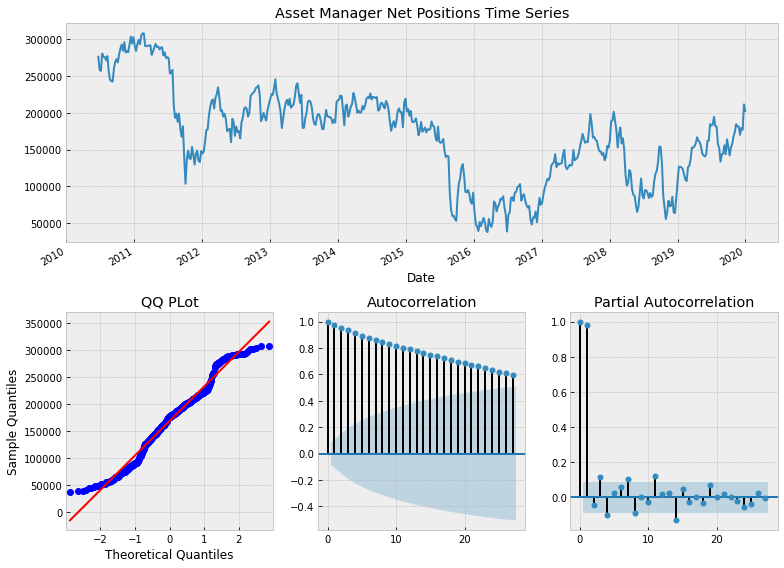

In [7]:
tsplot1(df_preCOV['AM_N'],title = 'Asset Manager Net Positions Time Series')

Estimating the Order of a Time Series Model

In [9]:
res = sm.tsa.arma_order_select_ic(df_preCOV['AM_N'], ic=['aic', 'bic'], trend = 'nc')
print("AIC Order Select:",res.aic_min_order)
print("BIC Order Select:",res.bic_min_order)

AIC Order Select: (2, 1)
BIC Order Select: (2, 1)


In [10]:
res = adfuller(df_preCOV['AM_N'])
print("ADF",res)

ADF (-2.229600319869047, 0.19567815476270017, 13, 479, {'1%': -3.44407586647939, '5%': -2.867592847097137, '10%': -2.5699939338217668}, 10282.138954684802)


For simplicity, we'll assume AM Net Positions are AR(1) and form our prediction around both the difference and level of the repsonse with the lagged response as a predictor.  There did not appear to be a strong indication for AR(2) in the PACF.

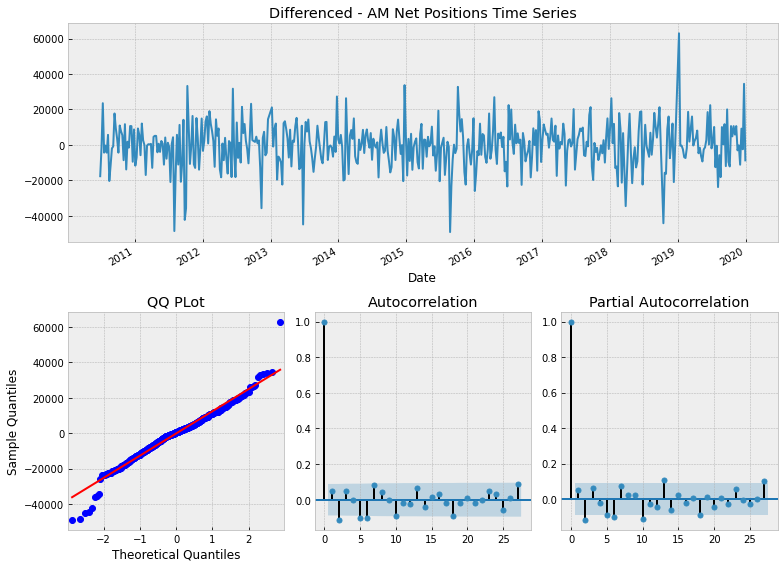

In [11]:
#Differencing
AM_N_diff = df_preCOV['AM_N'].diff().dropna()
tsplot1(AM_N_diff,title = 'Differenced - AM Net Positions Time Series')

In [12]:
res = sm.tsa.arma_order_select_ic(AM_N_diff, ic=['aic', 'bic'], trend = 'nc')
print("AIC Order Select:",res.aic_min_order)
print("BIC Order Select:",res.bic_min_order)

AIC Order Select: (1, 1)
BIC Order Select: (1, 1)


In [13]:
res = adfuller(AM_N_diff)
print("ADF",res)

ADF (-6.375196542001554, 2.2929558854773444e-08, 13, 478, {'1%': -3.4441047380903007, '5%': -2.867605550172837, '10%': -2.570000704119326}, 10264.65120388795)


### EDA: Predictors

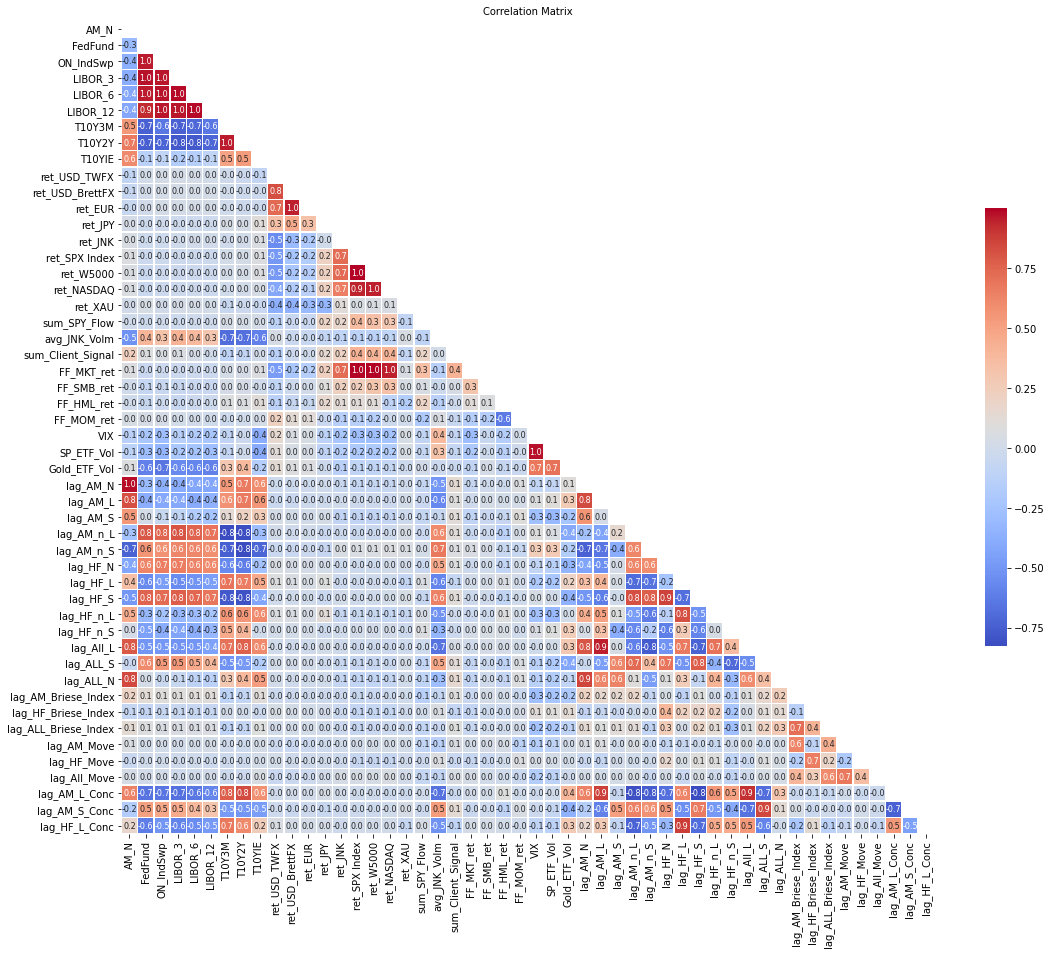

In [14]:
plotCorr(df,save=False)

#### Predictor Distributions

In [15]:
Asset = {'AM Position':['lag_AM_N','lag_AM_L','lag_AM_S'],
         'HF Position':['lag_HF_N','lag_HF_L','lag_HF_S'],
         'All Position':['lag_All_L', 'lag_ALL_S', 'lag_ALL_N'],
         'Concentration':['lag_AM_L_Conc', 'lag_AM_S_Conc','lag_HF_L_Conc', 'lag_HF_S_Conc'],
         'Sentiment':['lag_AM_Briese_Index', 'lag_HF_Briese_Index', 'lag_ALL_Briese_Index'],
         'Movement' :['lag_AM_Move','lag_HF_Move','lag_All_Move'],
         'Int_Rate':['FedFund', 'ON_IndSwp'],
         'LIBOR':['LIBOR_3', 'LIBOR_6','LIBOR_12'],
         'YTM Spread':['T10Y3M','T10Y2Y'],
         'Inflation':['T10YIE'],
         'FX Returns': [ 'ret_USD_TWFX','ret_USD_BrettFX', 'ret_EUR','ret_JPY'],      
         'Junk_Bond Returns':['ret_JNK'],
         'Equity Returns':['ret_SPX Index','ret_W5000', 'ret_NASDAQ'],
         'FamaFrench':['FF_MKT_ret', 'FF_SMB_ret', 'FF_HML_ret', 'FF_MOM_ret'],
         'ETF_Flows':['sum_SPY_Flow'],
         'Vol':['VIX', 'SP_ETF_Vol', 'Gold_ETF_Vol'],
         'Signal':['sum_Client_Signal'],
         'Commodity':['ret_XAU']       
        }
key_list = list(Asset.keys()) 

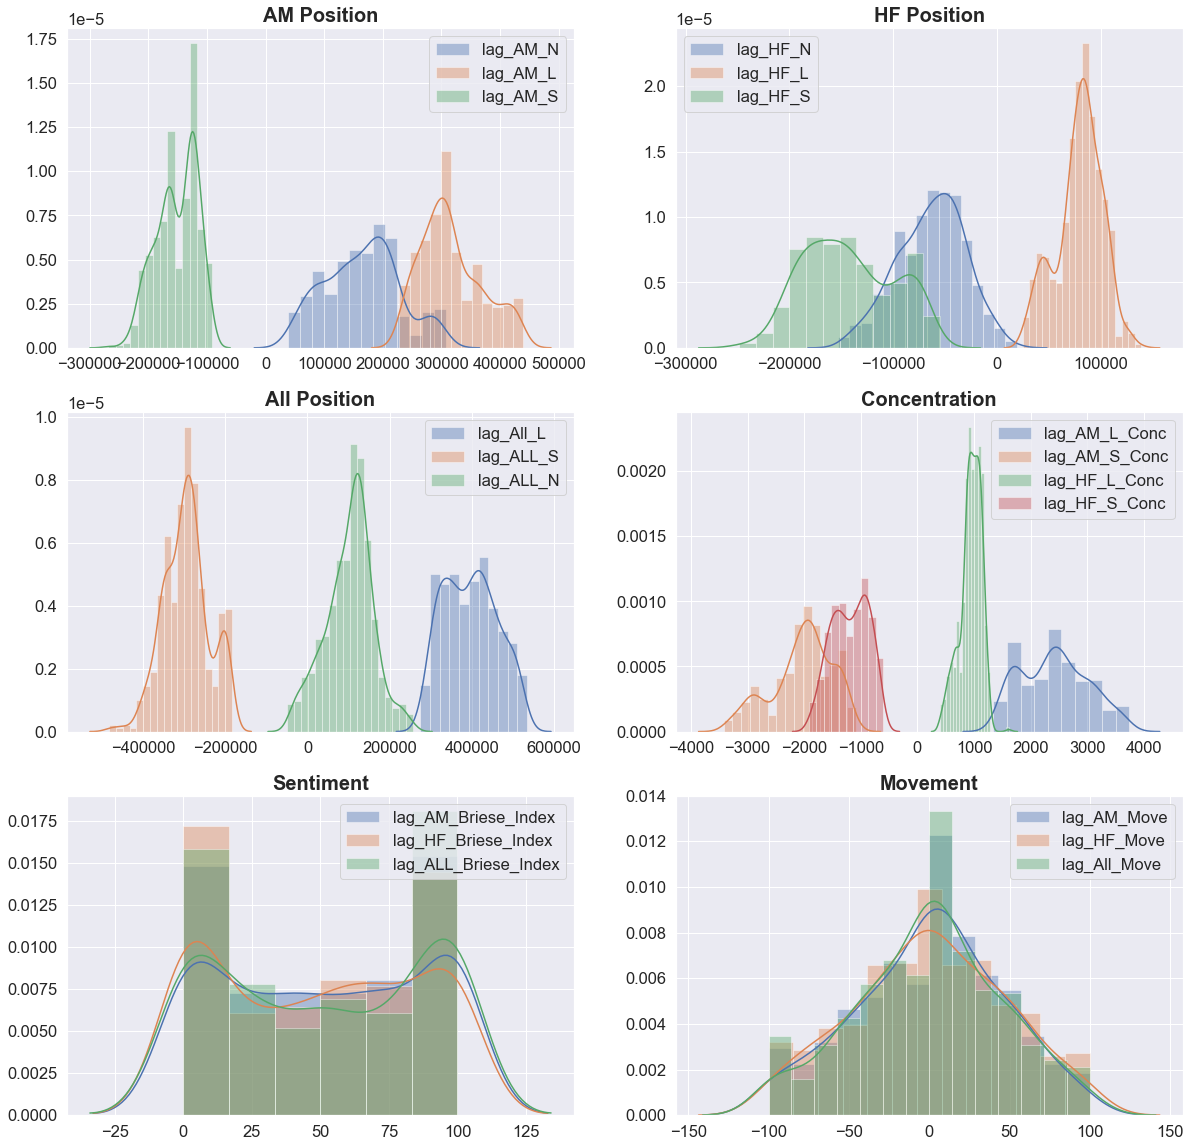

In [16]:
#look at one of each Asset Type Across Time
fig = plt.figure(figsize = (20,20))
sns.set(font_scale = 1.5)
axs = fig.subplots(3,2)
keys_cur = key_list[0:6]
for j in range(len(keys_cur)):    
    item_names = Asset[keys_cur[j]]
    for i in range(len(item_names)):
        axs[j//2, j%2].set_ylabel("Distribution", fontsize = 15)
        axs[j//2, j%2].set_ylabel("", fontsize = 15)
        axs[j//2, j%2].set_title(keys_cur[j], fontsize = 20,fontweight="bold")
        #if(item_names[i][-2:]=="_S"):
        #    x = pd.Series(-df.loc[:,item_names[i]], name = "")
        #else:
        x = pd.Series(df.loc[:,item_names[i]], name = "")
        sns.distplot(x, label = item_names[i],ax=axs[j//2,j%2])
    axs[j//2, j%2].legend()

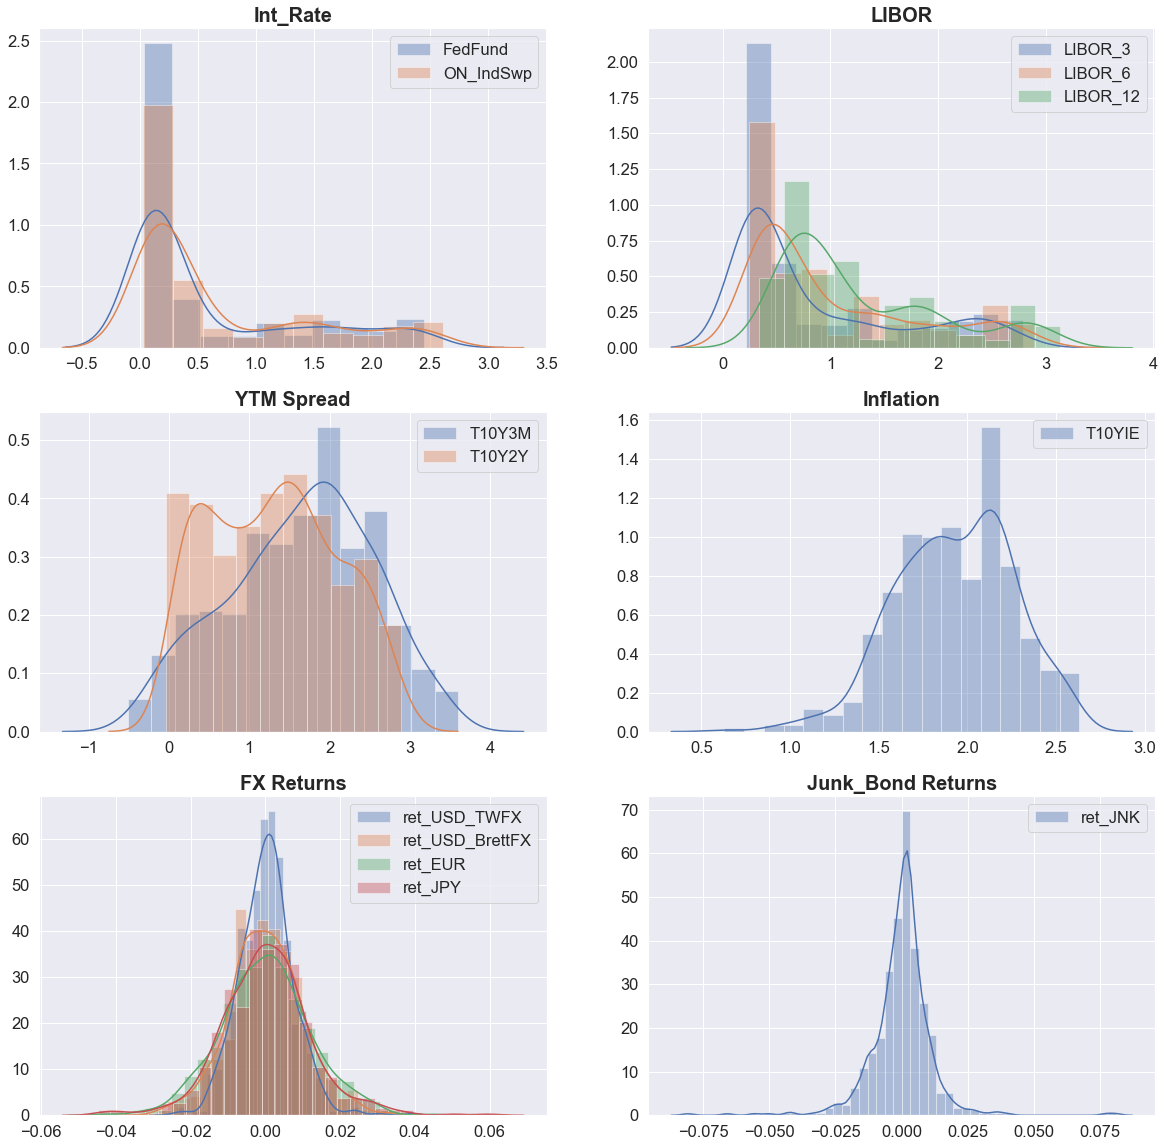

In [17]:
#look at one of each Asset Type Across Time
fig = plt.figure(figsize = (20,20))
sns.set(font_scale = 1.5)
axs = fig.subplots(3,2)
keys_cur = key_list[6:12]
for j in range(len(keys_cur)):    
    item_names = Asset[keys_cur[j]]
    for i in range(len(item_names)):
        axs[j//2, j%2].set_ylabel("Distribution", fontsize = 15)
        axs[j//2, j%2].set_ylabel("", fontsize = 15)
        axs[j//2, j%2].set_title(keys_cur[j], fontsize = 20,fontweight="bold")
        if(item_names[i][-6:]=="Signal"):
            scaler = preprocessing.StandardScaler()
            scaled_sig = scaler.fit_transform(df.loc[:,item_names[i]])
            x = pd.Series(scaled_sig, name = "")
        else:
            x = pd.Series(df.loc[:,item_names[i]], name = "")
        sns.distplot(x, label = item_names[i],ax=axs[j//2,j%2])
    axs[j//2, j%2].legend()

In [18]:
#standardize client signal
z = df['sum_Client_Signal']
z = z.dropna()
mean = np.mean(z)
std = np.std(z)
z = (z-mean)/std

#look at one of each Asset Type Across Time



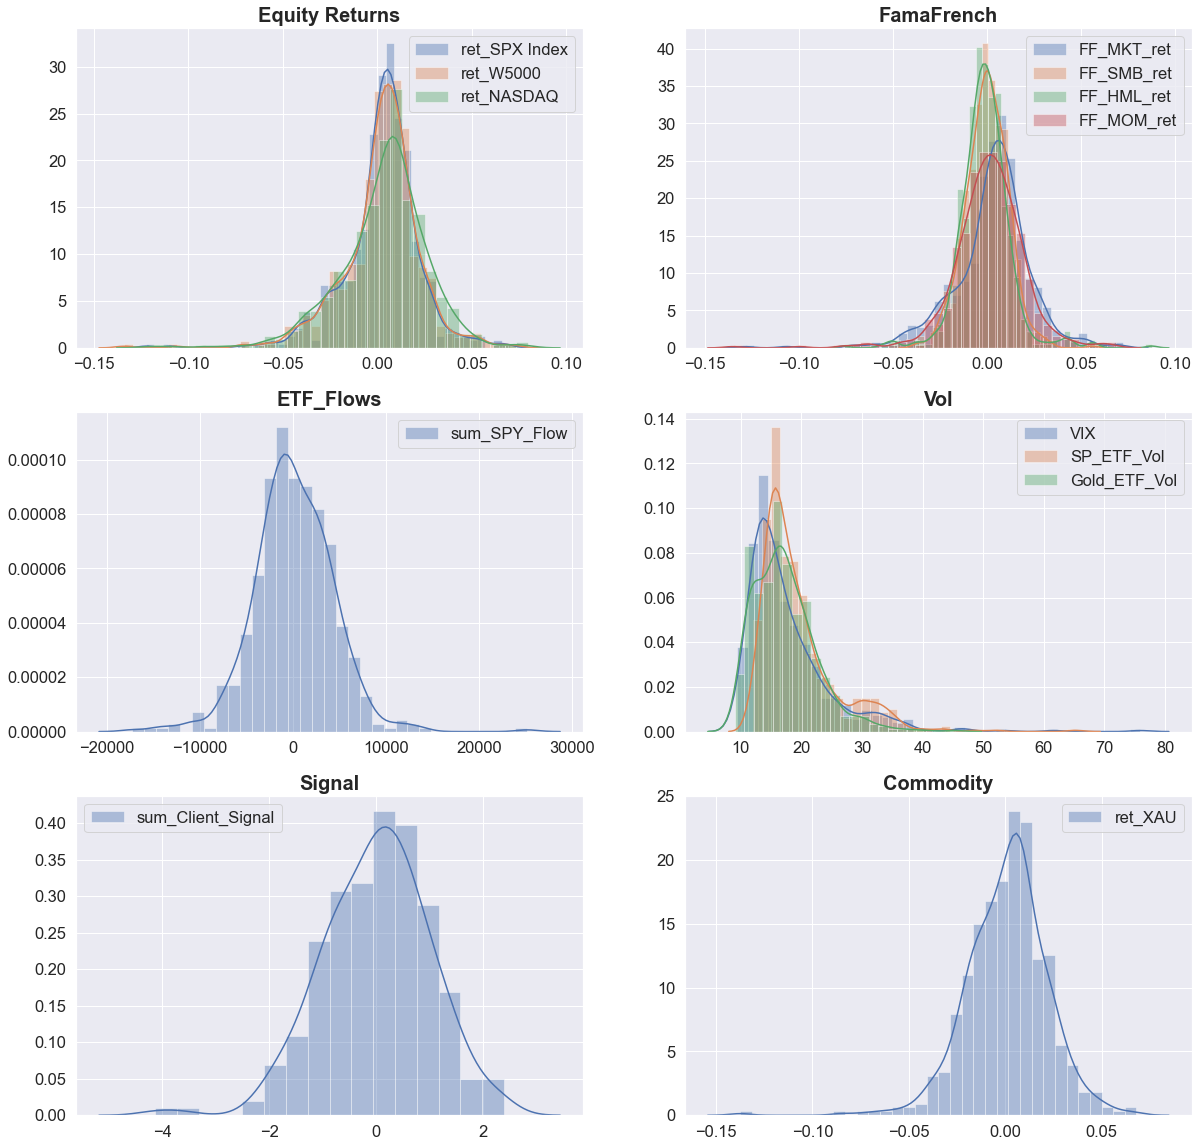

In [19]:
fig = plt.figure(figsize = (20,20))
sns.set(font_scale = 1.5)
axs = fig.subplots(3,2)
keys_cur = key_list[12:18]
for j in range(len(keys_cur)):    
    item_names = Asset[keys_cur[j]]
    for i in range(len(item_names)):
        axs[j//2, j%2].set_ylabel("Distribution", fontsize = 15)
        axs[j//2, j%2].set_ylabel("", fontsize = 15)
        axs[j//2, j%2].set_title(keys_cur[j], fontsize = 20,fontweight="bold")
        if(item_names[i][-6:]=="Signal"):
            x = pd.Series(z, name = "")
        else:
            x = pd.Series(df.loc[:,item_names[i]], name = "")
        sns.distplot(x, label = item_names[i],ax=axs[j//2,j%2])
    axs[j//2, j%2].legend()

#### Predictor / Response Correlations

In [20]:
df['year'] = df.index.year
y_train = df['AM_N']

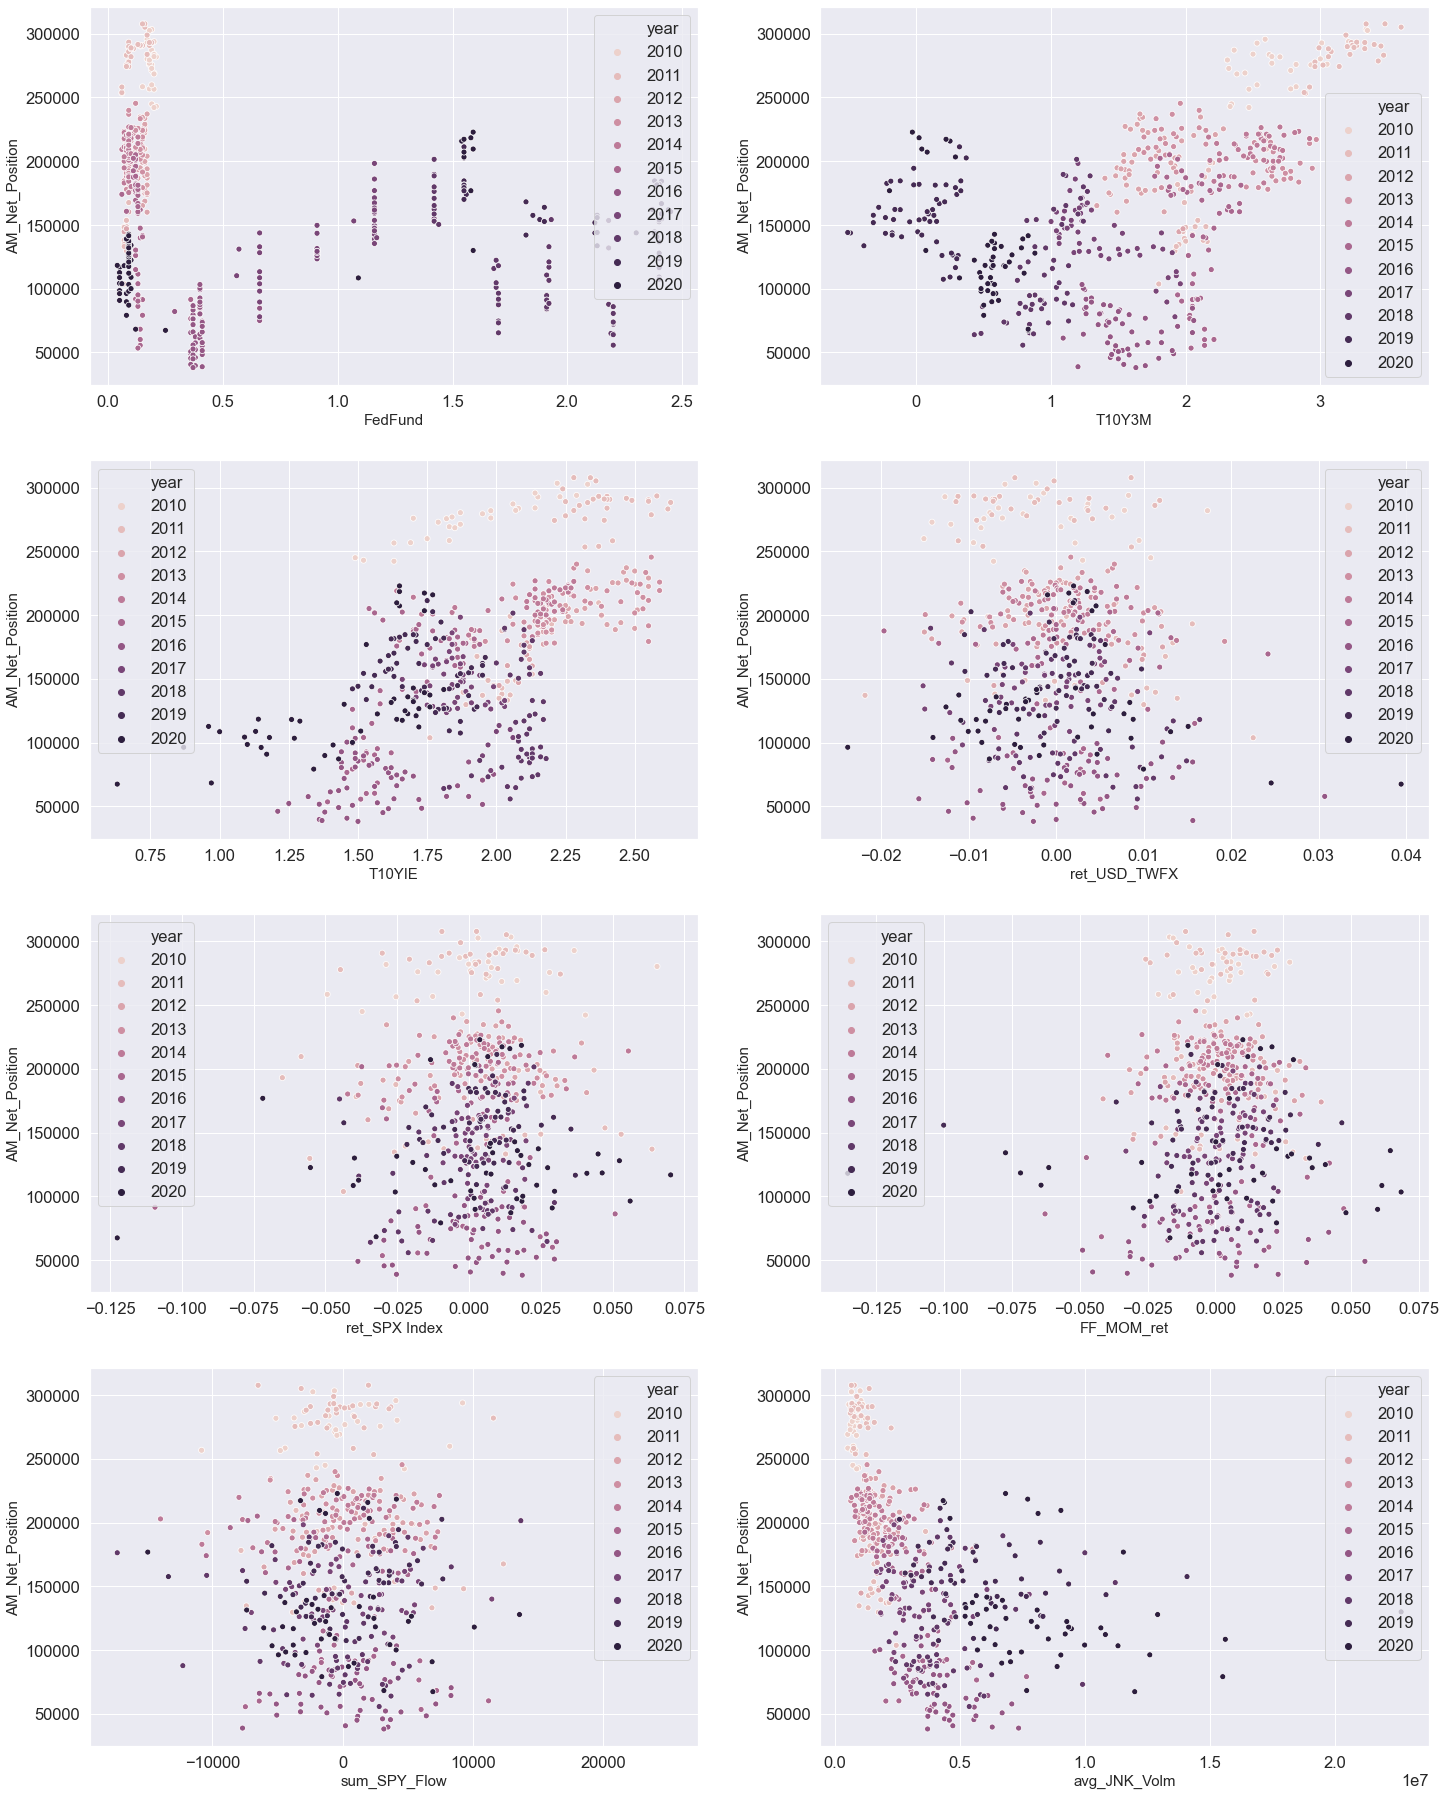

In [21]:
#look at one of each Asset Type Across Time
fig = plt.figure(figsize = (24,32))
sns.set(font_scale = 1.5)
axs = fig.subplots(4,2)
picklst = ['FedFund','T10Y3M','T10YIE','ret_USD_TWFX','ret_SPX Index','FF_MOM_ret','sum_SPY_Flow','avg_JNK_Volm']
for i in range(8):
    sns.scatterplot(x=df.loc[:,picklst[i]], y=y_train, data=df, hue="year",legend="full", ax=axs[i//2,i%2])
    axs[i//2, i%2].set_ylabel("AM_Net_Position", fontsize = 15)
    axs[i//2, i%2].set_xlabel(picklst[i], fontsize = 15)

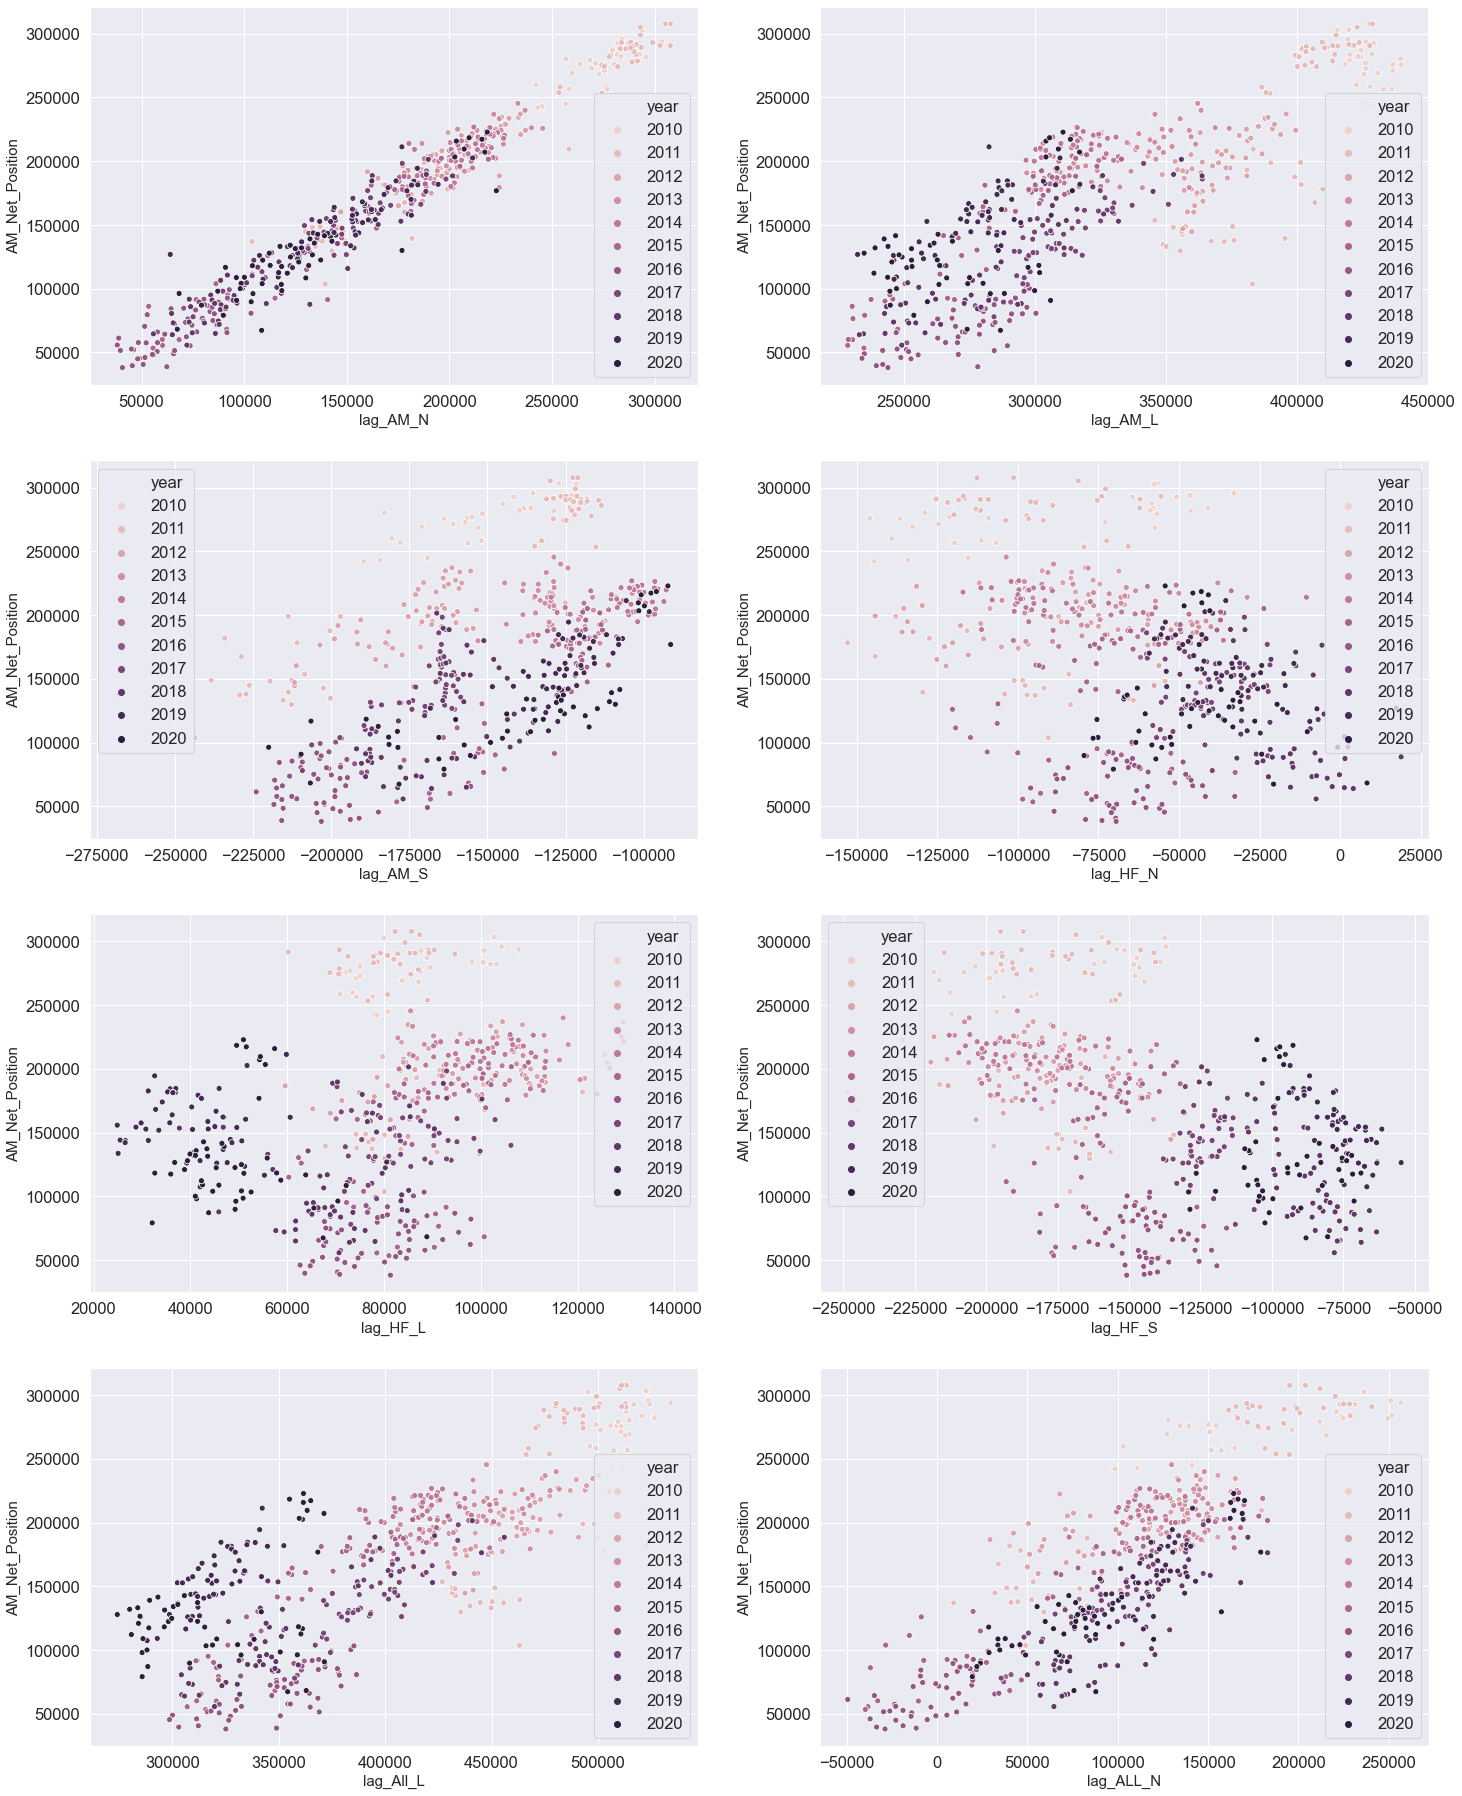

In [22]:
fig = plt.figure(figsize = (24,32))
sns.set(font_scale = 1.5)
axs = fig.subplots(4,2)
picklst = ['lag_AM_N','lag_AM_L', 'lag_AM_S', 'lag_HF_N', 'lag_HF_L', 'lag_HF_S', 'lag_All_L', 'lag_ALL_N']
for i in range(8):
    sns.scatterplot(x=df.loc[:,picklst[i]], y=y_train, data=df, hue="year",legend="full", ax=axs[i//2,i%2])
    axs[i//2, i%2].set_ylabel("AM_Net_Position", fontsize = 15)
    axs[i//2, i%2].set_xlabel(picklst[i], fontsize = 15)


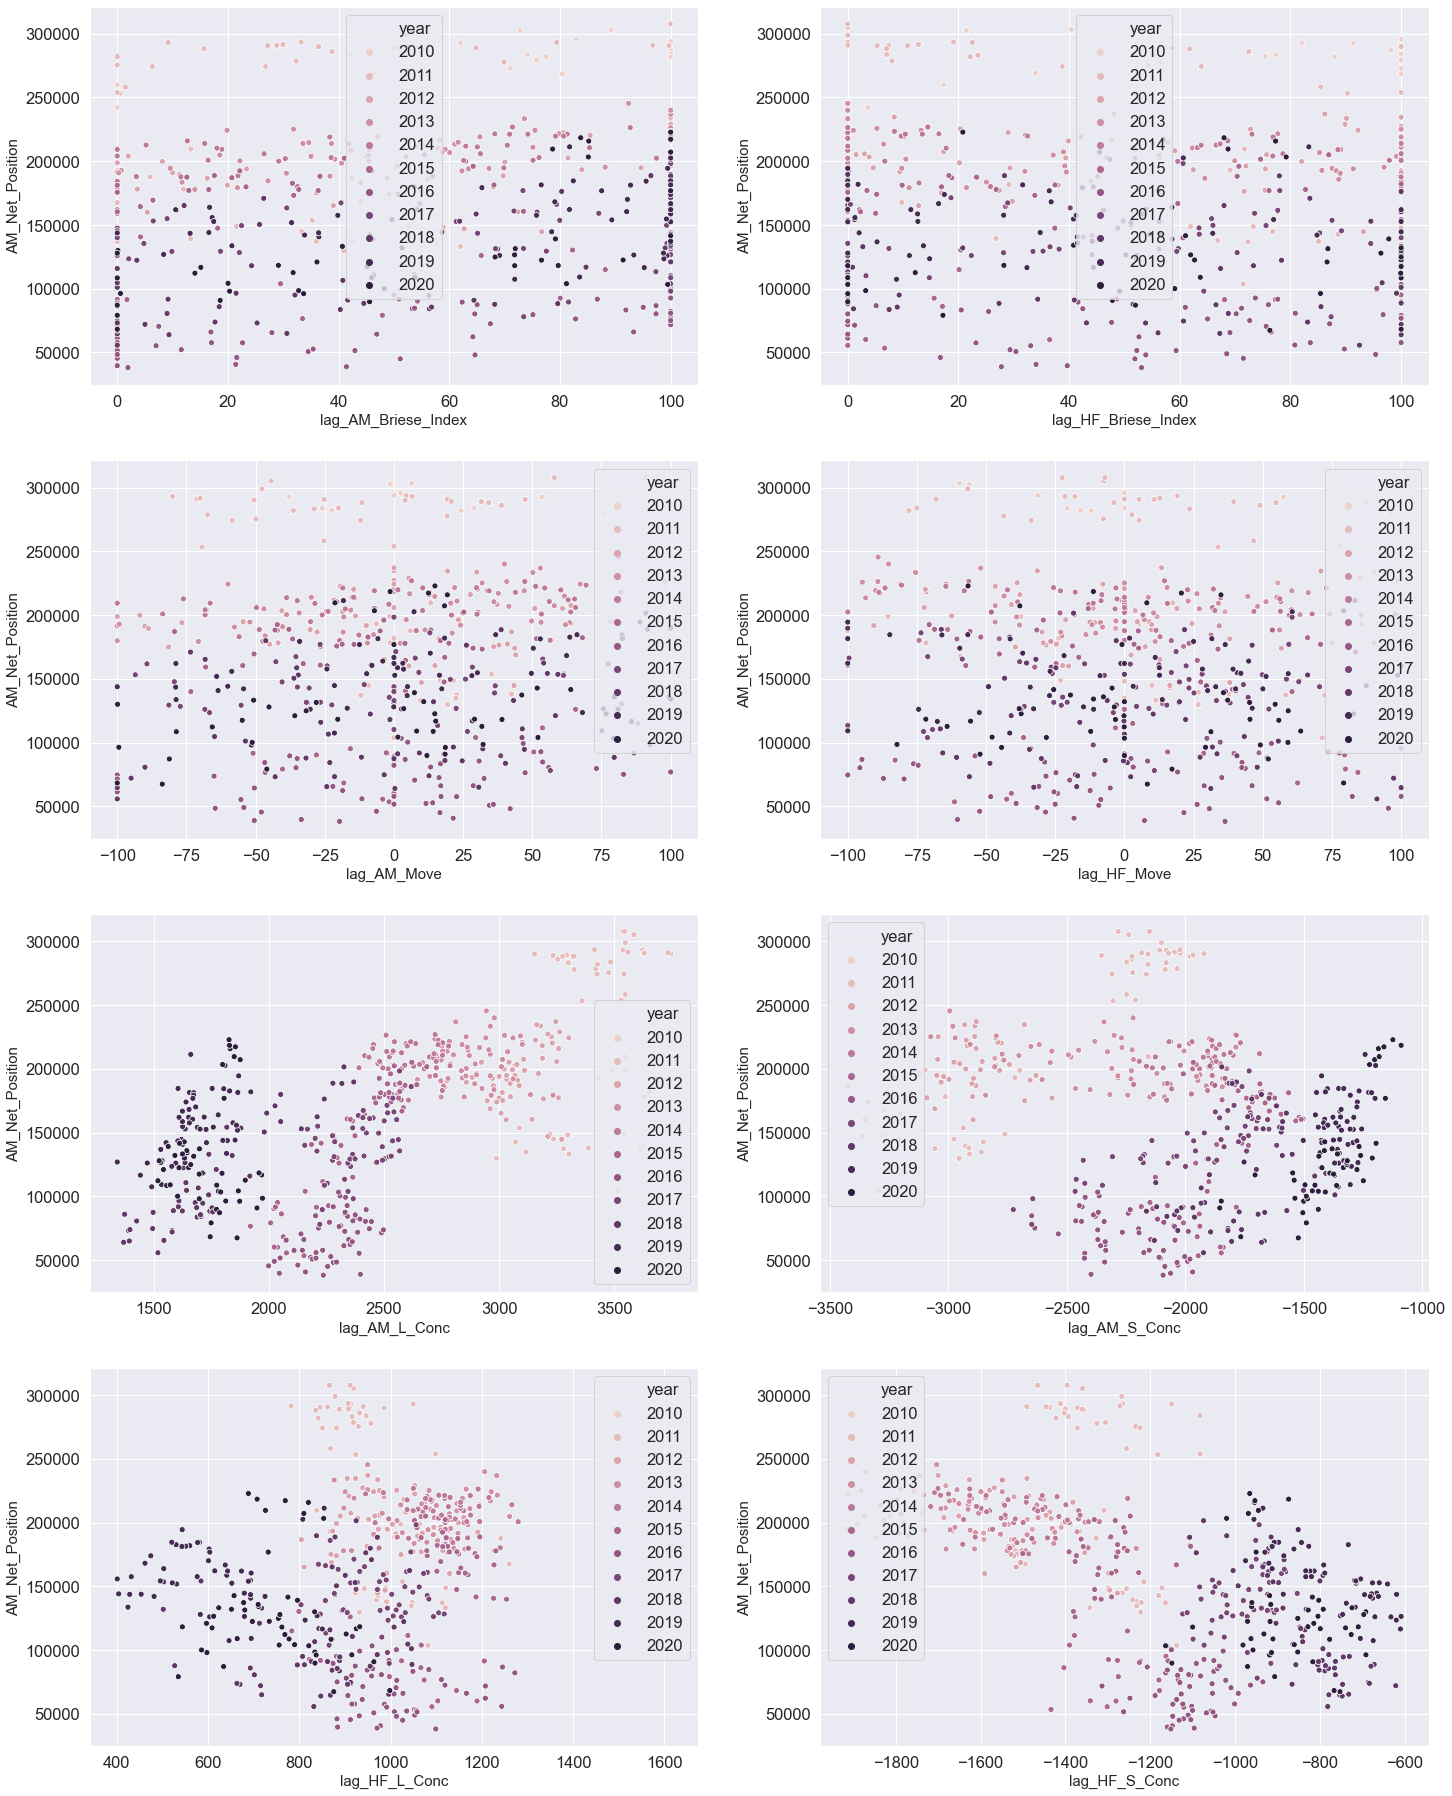

In [23]:
fig = plt.figure(figsize = (24,32))
sns.set(font_scale = 1.5)
axs = fig.subplots(4,2)
picklst = ['lag_AM_Briese_Index', 'lag_HF_Briese_Index','lag_AM_Move', 'lag_HF_Move', 
       'lag_AM_L_Conc', 'lag_AM_S_Conc', 'lag_HF_L_Conc', 'lag_HF_S_Conc']
for i in range(8):
    sns.scatterplot(x=df.loc[:,picklst[i]],y=y_train, data=df, hue="year",legend="full", ax=axs[i//2,i%2])
    axs[i//2, i%2].set_ylabel("AM_Net_Position", fontsize = 15)
    axs[i//2, i%2].set_xlabel(picklst[i], fontsize = 15)


## Benchmark Model
For the benchmark model, we will attempt to predict the AM_Net_Pos level based on the previous week's value.

In [24]:
y_train = df_train['AM_N']
X_train = df_train['lag_AM_N']
X_train = sm.add_constant(X_train)
y_test = df_test['AM_N']
X_test = df_test['lag_AM_N']
X_test = sm.add_constant(X_test)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

In [25]:
model = sm.OLS(y_train, X_train)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   AM_N   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                 1.181e+04
Date:                Thu, 17 Dec 2020   Prob (F-statistic):          1.22e-292
Time:                        17:35:26   Log-Likelihood:                -4211.5
No. Observations:                 390   AIC:                             8427.
Df Residuals:                     388   BIC:                             8435.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2911.0031   1719.576      1.693      0.0

Model: Benchmark
MSE is 21006.99
MAE is 10759.58
APE is 0.09


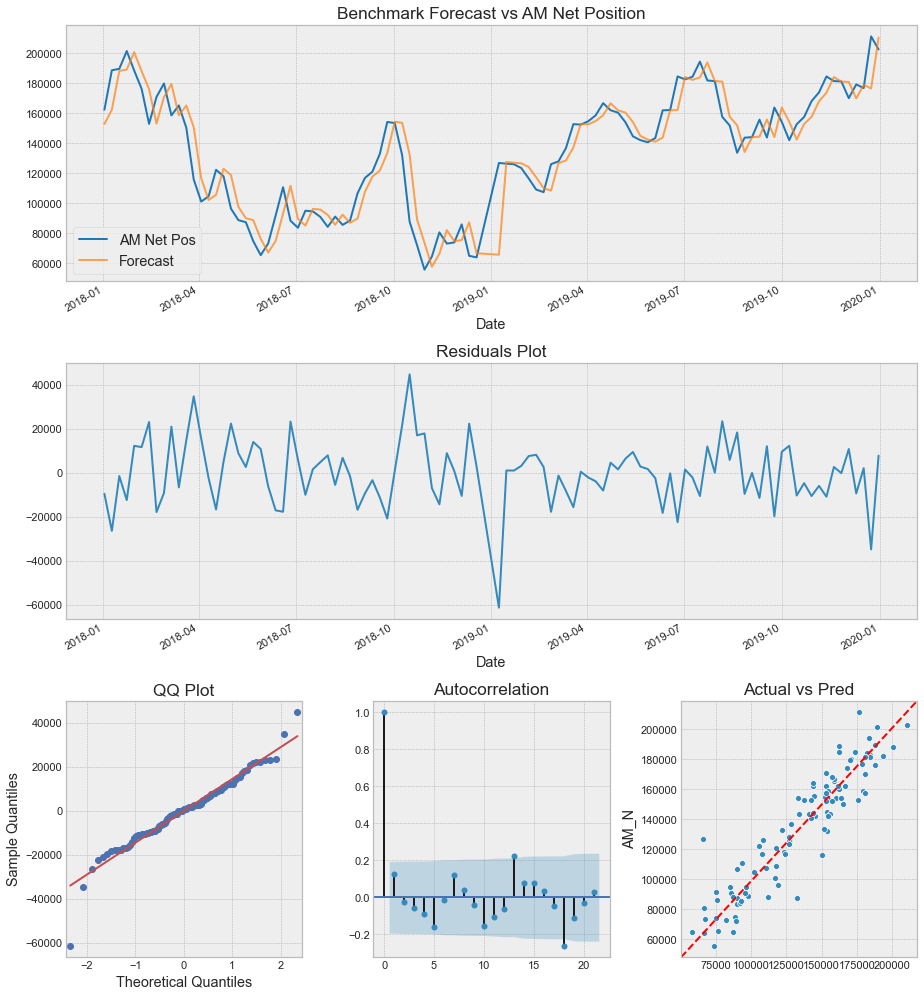

In [26]:
y_pred = results.predict(X_test)
evaluate('Benchmark', y_test, y_pred,'pos')

In [27]:
err = y_test-y_pred
scorecard('Benchmark',err,y_test,'dif')
ErrorTest(y_test,y_pred)

Model: Benchmark
MSE is 21006.99
MAE is 10759.58
APE is 0.09
    lb_stat  lb_pvalue
1  1.718218   0.189923
2  1.785893   0.409448
3  2.153454   0.541175 

AIC Order Select: (0, 1)
BIC Order Select: (0, 1)


## Position Forecast

#### Hidden Markov Model

In [28]:
train=pd.read_csv('raw_train_daily.csv')
test=pd.read_csv('raw_test_daily.csv')
train_state=pd.read_csv('train_state.csv')

train=train.iloc[:,1:] #
test=test.iloc[:,1:] #
train_state=train_state.iloc[:,1:] #

In [29]:
#train period 6/22/10 - 12/26/17; test 1/2/2018 - 12/31/2019
train.iloc[:1904,:]
train.to_csv('new_train_daily.csv',index=False)

test=pd.concat([train.iloc[1904:,:],test.iloc[:338,:]])
test.to_csv('new_test_daily.csv',index=False)

In [30]:
train=pd.read_csv('new_train_daily.csv')
test=pd.read_csv('new_test_daily.csv')
train_state=pd.read_csv('train_state.csv')

train_state=train_state.iloc[:,1:] #

In [31]:
#Original state are labelled as 2 for low and 1 for high (R)
#Now high state==1, low position state==0
train_state=2-train_state 
train_state.head()

x
0  1
1  1
2  1
3  1
4  1

In [32]:
def feature(train):
    train=train.drop(labels='Signal',axis=1)
    train=train.dropna()
    
    #1. Slope: since SPX proven to be the most predictive from Max's work
    train['SPX_1w_chg']=train['SPX']/train['SPX'].shift(1)-1 #weekly pct change
    train['SPX_2w_chg']=train['SPX']/train['SPX'].shift(2)-1 

    #2. Spread: for those highly correlated interest rates
    train['Spread_Libor_1YOIS']=train['Libor 1Y']-train['1Y OIS']

    #3. Lag: for comtemporary variables
    l=['AM_n_L', 'AM_n_S', 'Lev_n_L', 'Lev_n_S','AM_L', 'AM_S', 'Lev_L', 'Lev_S'] 
    newl=['last_'+s for s in l]
    train[newl]=train[l].shift(1)   #TS ARIMA potential
    train=train.drop(labels=l,axis=1)
    #remove signal becasue it's very sparse

    #4. Var

    #5. Cumsum

    #Comments: 1.daily signal 2.time series singal
    #train=train.drop(labels='Signal',axis=1)
    
    return train.dropna() #less the first two rows

In [33]:
#Benchmark: OLS
train=feature(train)
test=feature(test)
train_state=train_state.iloc[2:,]
#make sure number of weeks are the same
train.shape[0]==train_state.shape[0]

True

In [34]:
X=train.drop(columns = ['Time','AM_NetPos'])
y=train['AM_NetPos']
time_train=train['Time']

X_test=test.drop(columns = ['Time','AM_NetPos'])
y_test=test['AM_NetPos']
time_test=test['Time']

In [35]:
from sklearn.linear_model import LogisticRegression
y_state=np.array(train_state).reshape(len(train_state))
clf = LogisticRegression(random_state=0,max_iter=10000).fit(X.values, y_state)


In [36]:
#expected to see 1,1 because the initial states are high
clf.predict(X.iloc[:2, :].values)

array([1, 1], dtype=int64)

In [37]:
from sklearn.linear_model import LinearRegression
X_high=X.iloc[np.where(train_state==1)[0]]
y_high=y.iloc[np.where(train_state==1)[0]]
X_low=X.iloc[np.where(train_state==0)[0]]
y_low=y.iloc[np.where(train_state==0)[0]]

OLS_high = LinearRegression().fit(X_high, y_high)
OLS_low = LinearRegression().fit(X_low, y_low)

In [38]:
def evaluate(y,y_pred,title='Result'):
    mse=np.mean((y-y_pred)**2)
    mae=np.mean(np.abs(y-y_pred))
    ape=np.mean(np.abs((y-y_pred)/y))
    print(title,':')
    print('MSE is {}'.format(mse))
    print('MAE is {}'.format(mae))
    print('Average Percentage Error is {}'.format(ape))

In [39]:
#Test
test_state=clf.predict(X_test.values)
X_high_test=X_test.iloc[np.where(test_state==1)[0]]
X_low_test=X_test.iloc[np.where(test_state==0)[0]]
y_high_test=y_test.iloc[np.where(test_state==1)[0]]
y_low_test=y_test.iloc[np.where(test_state==0)[0]]

y_pred_test_high=OLS_high.predict(X_high_test)
y_pred_test_low=OLS_low.predict(X_low_test)

In [40]:
evaluate(y_high_test,y_pred_test_high,title='OLS High Test')
print('\n')
evaluate(y_low_test,y_pred_test_low,title='OLS Low Test')

OLS High Test :
MSE is 127675550.13164742
MAE is 9301.520800546887
Average Percentage Error is 0.05552549570650166


OLS Low Test :
MSE is 1069722615.904075
MAE is 25438.903177356573
Average Percentage Error is 0.21373145220343837


In [41]:
#merge the test prediction into a single test_pred array
y_pred_test=y_test.copy()
y_pred_test.iloc[np.where(test_state==0)[0]]=y_pred_test_low
y_pred_test.iloc[np.where(test_state==1)[0]]=y_pred_test_high
evaluate(y_test,y_pred_test,title='OLS Test')

OLS Test :
MSE is 705961867.7345235
MAE is 19207.636715024117
Average Percentage Error is 0.1526420234570965


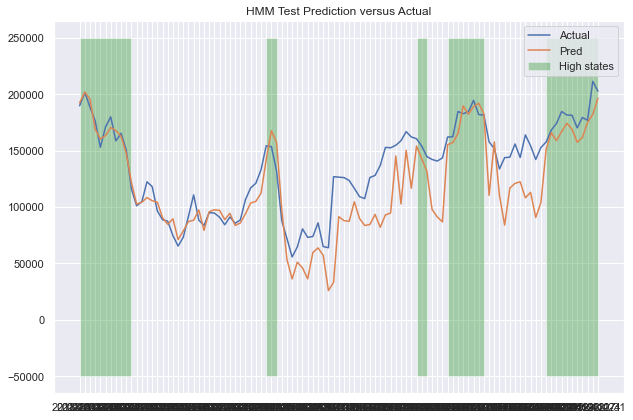

In [42]:
plt.figure(figsize=(9,6))
plt.plot(time_test,y_test,label='Actual')
plt.plot(time_test,y_pred_test,label='Pred')
plt.fill_between(time_test,-50000,250000,
                 where=(test_state==1),facecolor='green', alpha=0.3,label='High states')

plt.title('HMM Test Prediction versus Actual')
plt.legend()
plt.tight_layout()
plt.savefig('HMM Test Prediction',dpi=300)
plt.show()

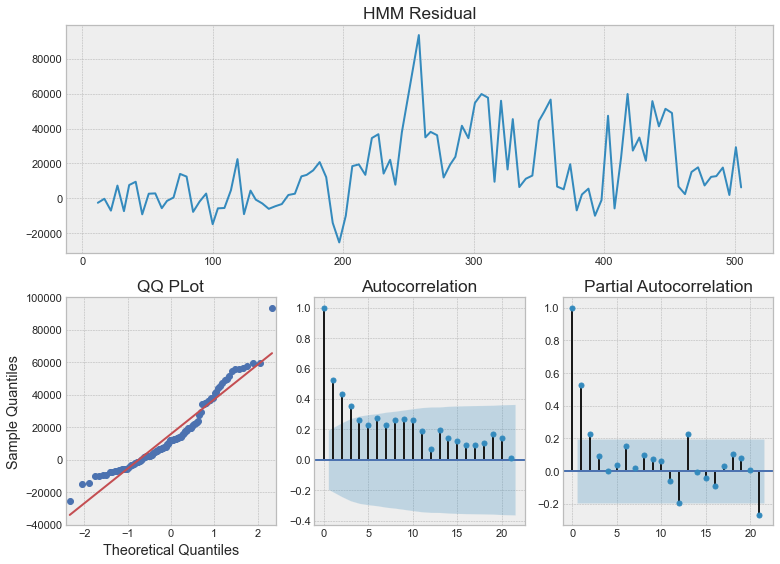

In [43]:
tsplot1(y_test-y_pred_test,title='HMM Residual')

In [44]:
scorecard('HMM',y_test-y_pred_test,y_test,'pos')
ErrorTest(y_test,y_pred_test)

Model: HMM
MSE is 70596.19
MAE is 19207.64
APE is 0.15
     lb_stat     lb_pvalue
1  28.486066  9.437523e-08
2  48.127557  3.541879e-11
3  61.441983  2.891471e-13 

AIC Order Select: (2, 1)
BIC Order Select: (1, 1)


In [45]:
i=0
n=8 #number of data points for each correlation: 8 points for around 2 months
l=np.array(train.shape)
#the variable index in the columns:
#'1Y OIS'(2), 'Libor 3 mo'(3),'JNK_Price'(9), 'SPX'(10)
ind=[2,3,]
np.corrcoef(train.iloc[i:i+n,1:],rowvar=False)[0,:]
#list(train.columns).index(['1Y OIS','Libor 3 mo'])
l=list(train.columns)

In [46]:
#Rolling correlation between positioning and other vars
a,b=train.shape
l=np.zeros((a-n+1,b-2)) #list of correlation: length minus (n-1), columns minus time and itself

n=8 #8 data points represents 2-month data
for i in range(len(train)-n+1):
    #every row of l is the correlation between Position and other variables
    l[i,:]=np.corrcoef(train.iloc[i:i+n,1:],rowvar=False)[0,1:]

In [47]:
#select those vars whose corr is significantly different from 0 as indicator for states
from scipy.stats import ttest_1samp
stat, p = ttest_1samp(l, popmean=0, axis=0)
sig=0.001

corr=l[:,p<sig]
pd.DataFrame(corr).to_csv('corr.csv')

col=train.columns[2:]
print('Significant Correlation Variables are:\n',col[p<sig].values)

Significant Correlation Variables are:
 ['1Y OIS' 'T10Y3M' 'T10Y2Y' 'T10YIE' 'JNK_Price' 'SPX' 'WILL5000INDFC'
 'NASDAQCOM' 'GOLD_price' 'VIX' 'VXVCLS' 'GVZCLS' 'JPY' 'EUR' 'USDX_Close'
 'DTWEXBGS' 'Lev_NetPos' 'JNK_Volume' 'SPX_1w_chg' 'SPX_2w_chg'
 'Spread_Libor_1YOIS' 'last_AM_L' 'last_AM_S']


#### VARMAX

In [50]:
df=pd.read_csv('train_weekly.csv')
df['Time']=pd.to_datetime(df['Time'])#,format='%Y-%m-%d')
Time=df['Time']
df=df.iloc[:,:]
df=df.drop(['Signal'],axis=1)
dp=np.zeros(len(df))
pp=np.zeros(len(df))
for i in range(1,len(df)):
    dp[i]=df['AM_NetPos'][i]-df['AM_NetPos'][i-1]
    pp[i]=df['AM_NetPos'][i-1]
df['DP']=dp
df['Prev_pos']=pp
df=df.drop(["Lev_NetPos","AM_n_L","AM_n_S","Lev_n_L","Lev_n_S","AM_L","AM_S","Lev_L","Lev_S",'AM_NetPos','Time'],axis=1).drop(0)

In [51]:
y=df['DP']
X=df.drop(['DP'],axis=1)
X = sm.add_constant(X)
model_OLS = sm.OLS(y, X).fit()
a=model_OLS.pvalues
for i in range(5):
    X_loop=X.iloc[i:,:]
    y_loop=y.shift(i).dropna()
    X_loop = sm.add_constant(X_loop)
    model_OLS = sm.OLS(y_loop, X_loop).fit()
    a+=model_OLS.pvalues
# print(a.sort_values())
selected=['Prev_pos', 'GOLD_price', 'JNK_Volume', 'NASDAQCOM','WILL5000INDFC', 'SPX', 'Libor 6 mo']

#### VAR

In [52]:
# deal with the extra lag for positioning
Varmax_df=df[np.append(selected,'DP')]
#dpos = (pos-pos.shift(1)).dropna()
#Varmax_df['dpos']=dpos

In [53]:
MSE=[]
APE=[]
MAE=[]
predicted=[]
true=[]
start = time.time()
for i in range(350,len(Varmax_df)):
    #assume stationarity at first
    y_val=Varmax_df['DP'].iloc[i]
    mod = VAR(Varmax_df.iloc[:i,:]).fit(3)
    prediction=mod.forecast(np.array(Varmax_df.iloc[:i,:]),1)
    pos_index=[i for i, j in enumerate(Varmax_df.columns) if j == 'DP']
    y_predict=prediction[0][pos_index]
    predicted.append(y_predict+df['Prev_pos'].iloc[i])
    true.append(y_val+df['Prev_pos'].iloc[i])

    mse=(y_val-y_predict)**2
    ape=np.abs((y_val-y_predict)/(df['DP'].iloc[i]+df['Prev_pos'].iloc[i]))
    MSE.append(mse)
    APE.append(ape)
    mae=np.abs((y_val-y_predict))
    MAE.append(mae)
    
true=pd.Series(true,index=Time[351:])
predicted=pd.Series(predicted,index=Time[351:])
end = time.time()
print('VAR Selection: ')
print('MSE is ',np.mean(MSE))
print('Average Percentage Error is ' , np.mean(APE) )
print('Time elapsed: ',end-start)
print('MAE is ',np.mean(MAE))
#plt.scatter(predicted,true)
type(predicted)

VAR Selection: 
MSE is  144321860.743228
Average Percentage Error is  0.07275392492188677
Time elapsed:  0.7593095302581787
MAE is  9389.491258771535


##### Transformation

In [54]:
MSE=[]
APE=[]
MAE=[]
predicted=[]
true=[]
start = time.time()
for i in range(350,len(Varmax_df)):
    #assume stationarity at first
    y_val=Varmax_df['DP'].iloc[i]
    transformer = Normalizer().fit(Varmax_df.iloc[:i,:].drop(['DP'],axis=1))
    Trans=transformer.transform(Varmax_df.iloc[:i,:].drop(['DP'],axis=1))
    trans_df=np.append(Trans,np.array(Varmax_df['DP'].iloc[:i]).reshape(i,1),1)
    mod = VAR(trans_df).fit(3)
    prediction=mod.forecast(trans_df,1)
    pos_index=[i for i, j in enumerate(trans_df) if j == 'DP']
    y_predict=prediction[0][-1]
    mse=(y_val-y_predict)**2
    ape=np.abs((y_val-y_predict)/(df['DP'].iloc[i]+df['Prev_pos'].iloc[i]))
    predicted.append(y_predict+df['Prev_pos'].iloc[i])
    true.append(y_val+df['Prev_pos'].iloc[i])
    MSE.append(mse)
    APE.append(ape)
    mae=np.abs(y_val-y_predict)
    MAE.append(mae)
end = time.time()
print('VAR Transformation: ')
print('MSE is ',np.mean(MSE))
print('Average Percentage Error is ' , np.mean(APE) )
print('Time elapsed: ',end-start)
print('MAE is ',np.mean(MAE))
#plt.scatter(predicted,true)

VAR Transformation: 
MSE is  147515448.7031878
Average Percentage Error is  0.07559822895781444
Time elapsed:  2.9488906860351562
MAE is  9656.206682696939


##### VARMAX

In [55]:
MSE=[]
APE=[]
MAE=[]
start = time.time()
for i in range(350,len(Varmax_df)):
    y_val=Varmax_df['DP'].iloc[i]
    mod = sm.tsa.VARMAX(Varmax_df.iloc[:i,[0,1,7]], order=(0,2), error_cov_type='diagonal')
    res = mod.fit(maxiter=1000, disp=False)
    prediction=res.forecast(1)
    #pos_index=[i for i, j in enumerate(Varmax_df.columns) if j == 'DP']
    y_predict=prediction['DP'].iloc[0]
    mse=(y_val-y_predict)**2
    ape=np.abs((y_val-y_predict)/(df['DP'].iloc[i]+df['Prev_pos'].iloc[i]))
    MSE.append(mse)
    APE.append(ape)
    mae=np.abs(y_val-y_predict)
    MAE.append(mae)
end = time.time()
print('VARMAX Selection: ')
print('MSE is ',np.mean(MSE))
print('Average Percentage Error is ' , np.mean(APE) )
print('Time elapsed: ',end-start)
print('MAE is ',np.mean(MAE))
true=pd.Series(true,index=Time[351:])
predicted=pd.Series(predicted,index=Time[351:])

VARMAX Selection: 
MSE is  65816470656.205345
Average Percentage Error is  0.29414044261937483
Time elapsed:  350.43781661987305
MAE is  47706.26486430489


VAR Transformation: 
MSE is  143936256.62997085
Average Percentage Error is  0.07237884979239888
Time elapsed:  420.08468794822693
MAE is  9329.59696163085


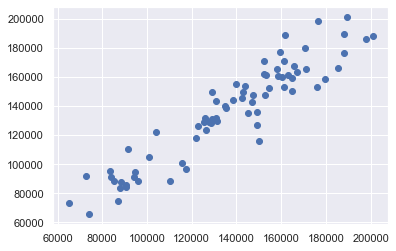

In [56]:

MSE=[]
APE=[]
MAE=[]
predicted=[]
true=[]
start = time.time()
transformer = Normalizer().fit(Varmax_df.iloc[:,:].drop(['DP'],axis=1))
Trans=transformer.transform(Varmax_df.iloc[:,:].drop(['DP'],axis=1))
trans_df=np.append(Trans,np.array(Varmax_df['DP']).reshape(len(Trans),1),1)
                   
for i in range(350,len(Varmax_df)):
    y_val=Varmax_df['DP'].iloc[i]
    mod = sm.tsa.VARMAX(trans_df[:i,[0,2,7]],order=(1,2), error_cov_type='diagonal')
    res = mod.fit()
    #pos_index=[i for i, j in enumerate(trans_df) if j == 'DP']
    y_predict=prediction['DP'].iloc[0]
    mse=(y_val-y_predict)**2
    ape=np.abs((y_val-y_predict)/(df['DP'].iloc[i]+df['Prev_pos'].iloc[i]))
    predicted.append(y_predict+df['Prev_pos'].iloc[i])
    true.append(y_val+df['Prev_pos'].iloc[i])
    MSE.append(mse)
    APE.append(ape)
    mae=np.abs(y_val-y_predict)
    MAE.append(mae)
end = time.time()
print('VAR Transformation: ')
print('MSE is ',np.mean(MSE))
print('Average Percentage Error is ' , np.mean(APE) )
print('Time elapsed: ',end-start)
print('MAE is ',np.mean(MAE))
true=pd.Series(true,index=Time[351:])
predicted=pd.Series(predicted,index=Time[351:])
plt.scatter(predicted,true)

In [58]:
true = pd.Series(true, index = )
evaluate('VARMAX', true, predicted,'dif')

TypeError: unsupported operand type(s) for -: 'list' and 'list'

#### Lasso
We begin with a rolling estimation window as a way to address local changes in predictor relationships

In [48]:
pred, MSE, MAE, APE, var_sel, y_true, idx = Rolling('Lasso',123,5)
rebal_dates, rebal_count = Rebal_Dates(df_preCOV, 123, 5)

In [49]:
evaluate('Lasso', y_true, pred,'pos')

TypeError: evaluate() takes from 2 to 3 positional arguments but 4 were given

In [ ]:
ErrorTest(y_true,pred)

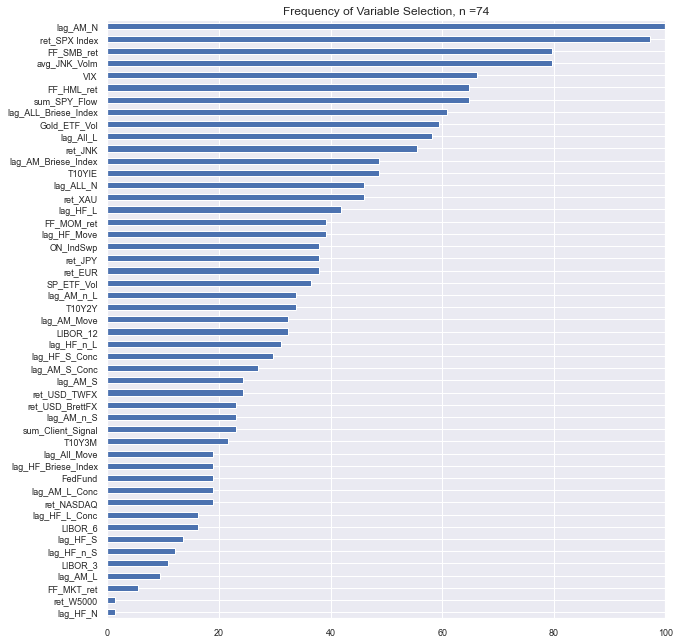

In [27]:
fig = plt.figure(figsize = (10,11))
selected = list(var_sel.values())
flat_sel = [item for sublist in selected for item in sublist]
sel = pd.Series(flat_sel)
pct = sel.value_counts()/rebal_count*100
pct.plot(kind='barh', xlim=(0,100), stacked = True, fontsize = 9)
plt.gca().invert_yaxis()
plt.title("Frequency of Variable Selection, n ="+str(rebal_count))
plt.show()

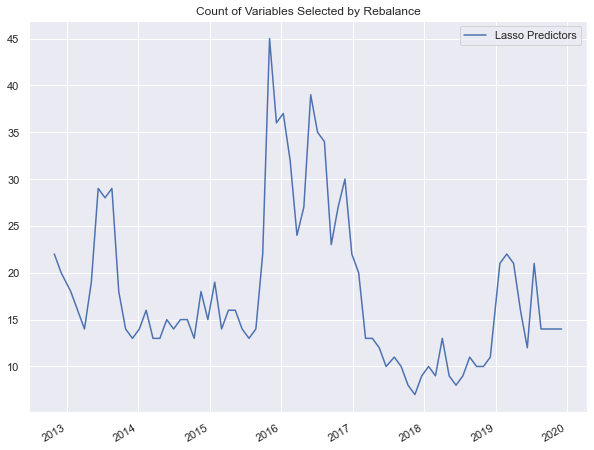

In [28]:
sns.set(font_scale = 1)
length_dict = {key: len(value) for key, value in var_sel.items()}
var_count = list(length_dict.values())
var_count = pd.Series(var_count, index = rebal_dates)
var_count.plot(kind = 'line',title = "Count of Variables Selected by Rebalance", label = "Lasso Predictors", figsize = (10,8))
plt.legend()
plt.show()


#### Ridge

In [29]:
pred, MSE, MAE, APE, var_sel, y_true, idx = Rolling('Ridge',123,5)


Model: Ridge
MSE is 171.25
MAE is 9769.35
APE is 0.09


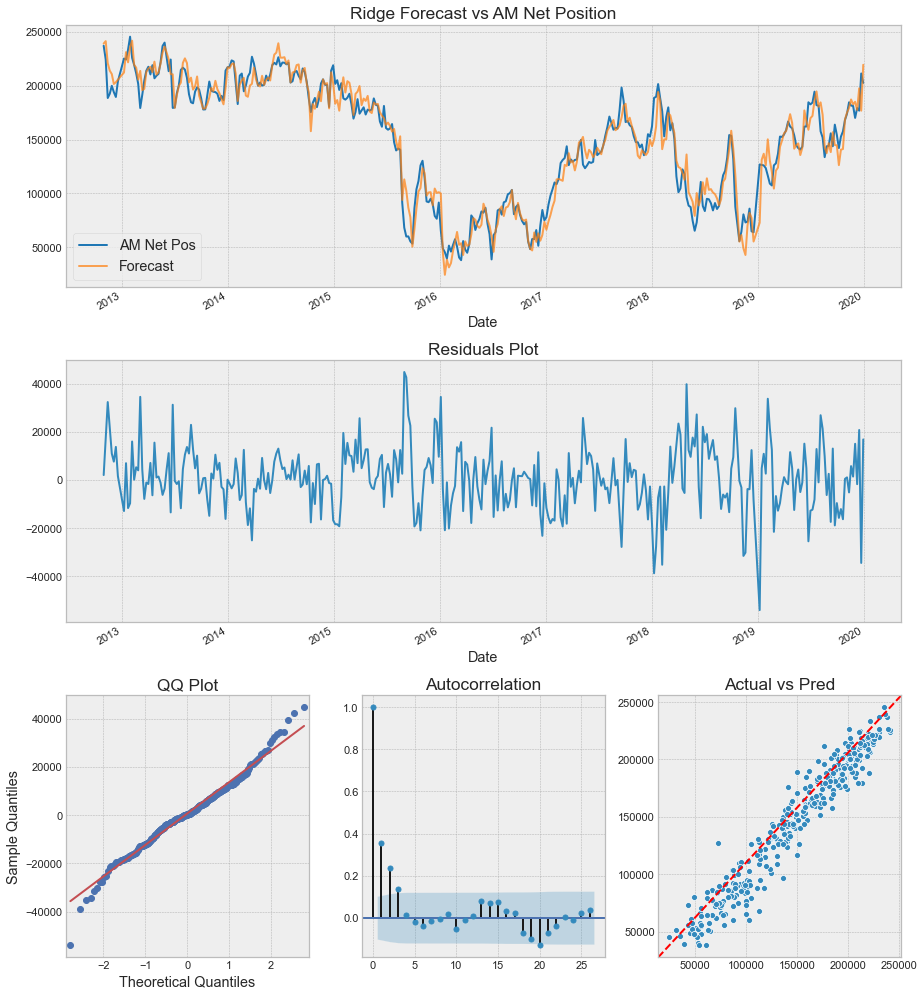

In [30]:
evaluate('Ridge', y_true, pred,'pos')

In [31]:
ErrorTest(y_true,pred)

     lb_stat     lb_pvalue
1  46.572463  8.829229e-12
2  67.815003  1.880006e-15
3  74.711478  4.177755e-16 

AIC Order Select: (2, 0)
BIC Order Select: (2, 0)


#### Elastic Net

In [32]:
pred, MSE, MAE, APE, var_sel, y_true, idx = Rolling('ElasticNet',123,5)

Model: ElasticNet
MSE is 187.14
MAE is 10247.05
APE is 0.09


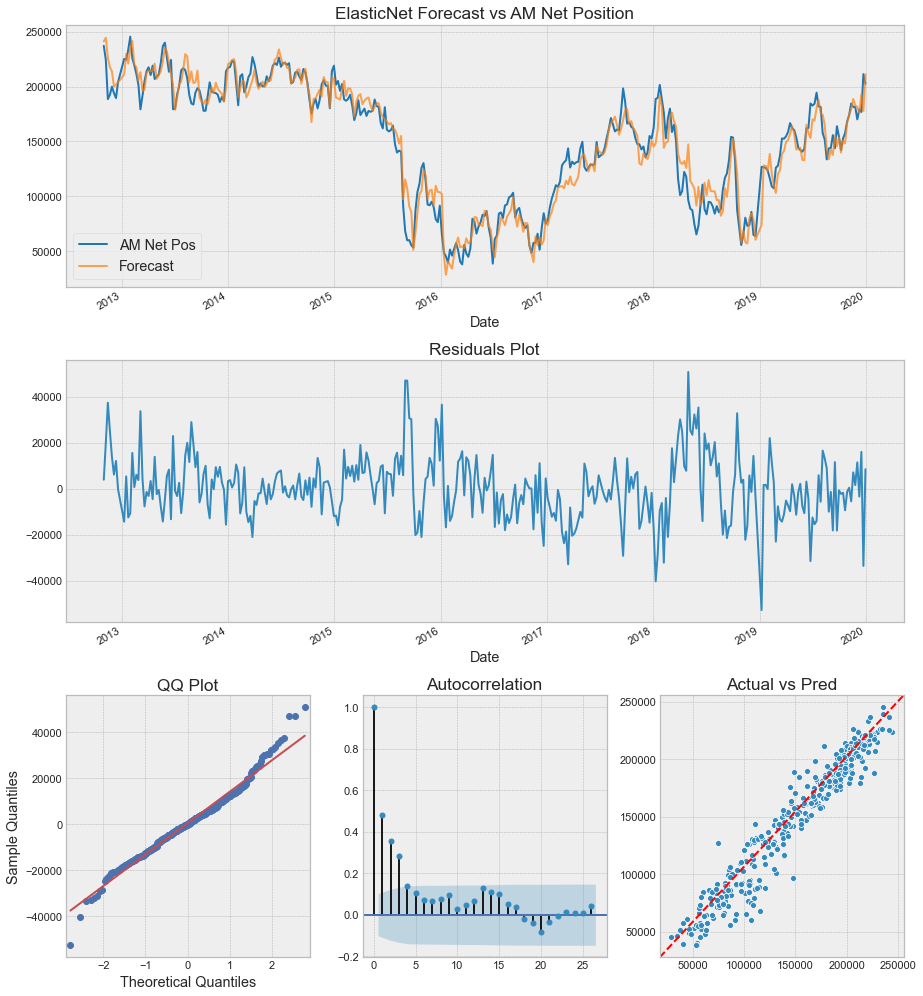

In [33]:
evaluate('ElasticNet', y_true, pred,'pos')

In [34]:
ErrorTest(y_true,pred)

      lb_stat     lb_pvalue
1   85.775959  2.015213e-20
2  133.002446  1.314879e-29
3  162.773831  4.618362e-35 

AIC Order Select: (3, 1)
BIC Order Select: (1, 1)


#### SVR

In [41]:
pred, MSE, MAE, APE, var_sel, y_true, idx = Rolling('SVReg',223,9)

Model: SVReg
MSE is 3520.93
MAE is 46852.07
APE is 0.58


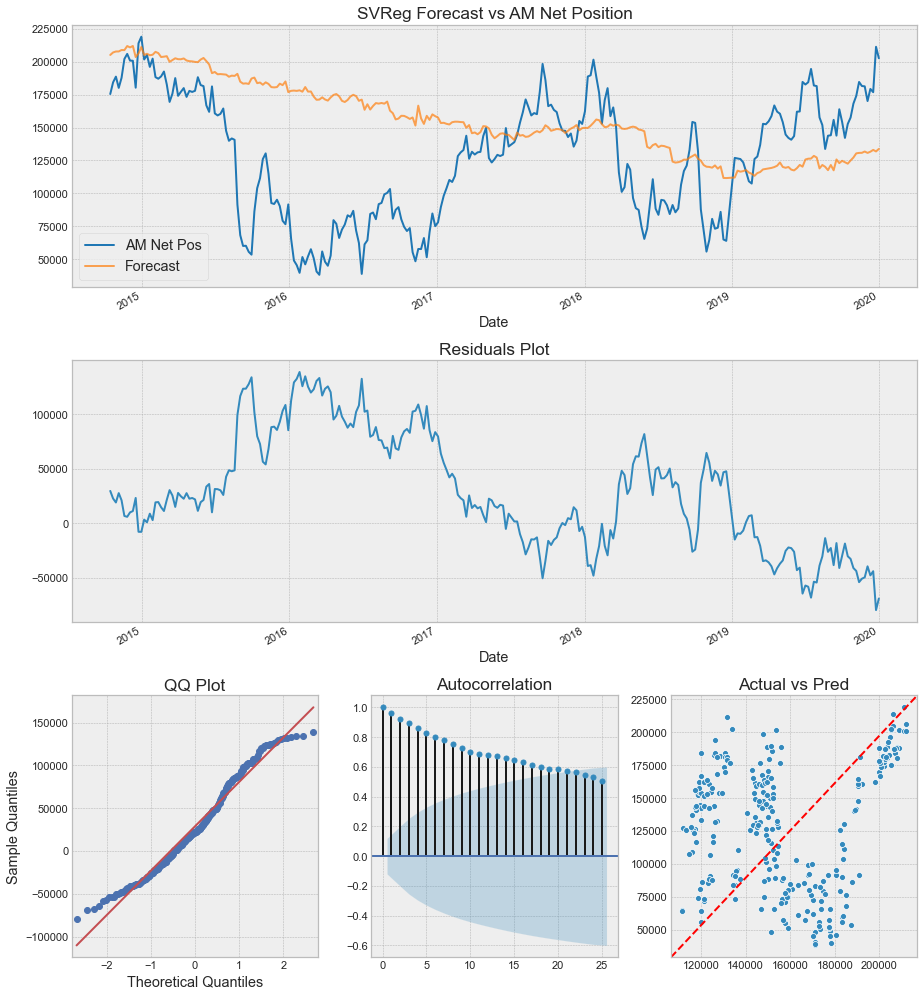

In [42]:
evaluate('SVReg', y_true, pred,'pos')

#### Random Forest

__Random Forest__

In [38]:
pred, MSE, MAE, APE, var_sel, y_true, idx = Expanding('RF',153,17)

Model: RF
MSE is 590.80
MAE is 18166.17
APE is 0.18


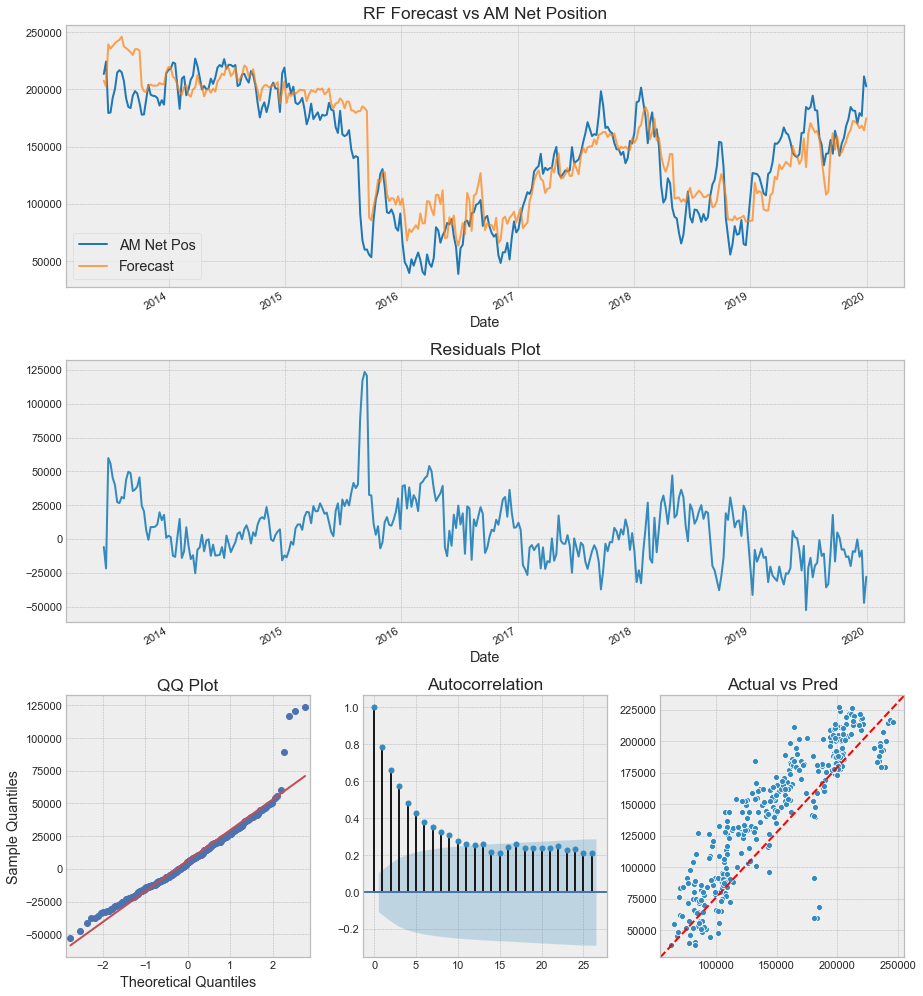

In [39]:
evaluate('RF', y_true, pred,'pos')

__Variable Selection with Random Forest__

In [45]:
tscv = TimeSeriesSplit(n_splits = 5)
X_train = df_train.iloc[:,1:]
y_train = df_train.iloc[:,0]
X_test = df_test.iloc[:,1:]
y_test = df_test.iloc[:,0]

#standardize our predictors (std 1, mean 0)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

feat_importance, forecast = RF(X_train_std, X_test_std, X_train, y_train,tscv)

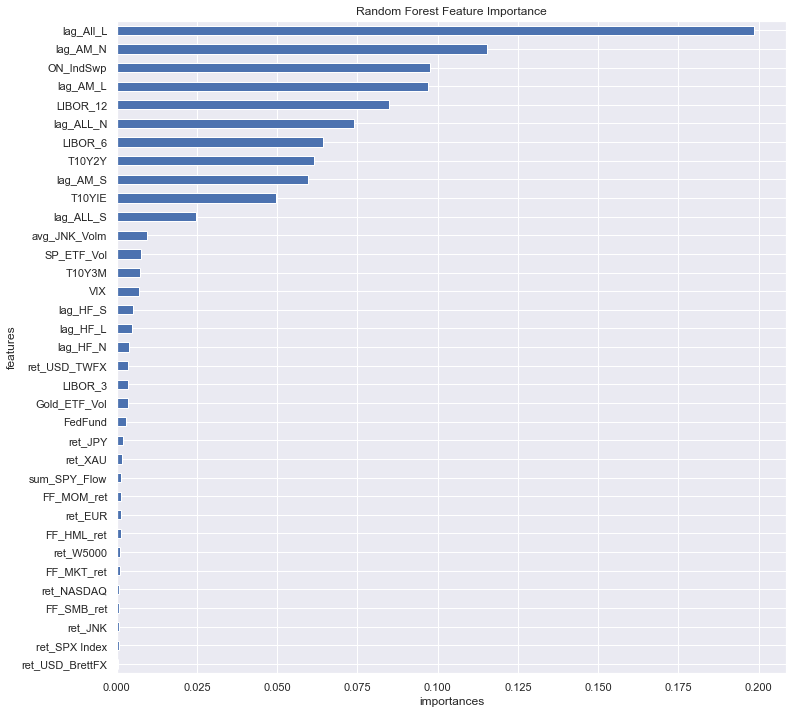

In [46]:
fis = np.argsort(feat_importance)
feat_importance = feat_importance[fis]
fig = plt.figure(figsize = [12,12])
ax = fig.subplots(1,1)
feat_importance.plot(kind = 'barh', ax = ax)
plt.ylabel('features')
plt.xlabel('importances')
plt.title("Random Forest Feature Importance")
plt.show()

Model: RF_Single
MSE is 830.64
MAE is 24845.43
APE is 0.20


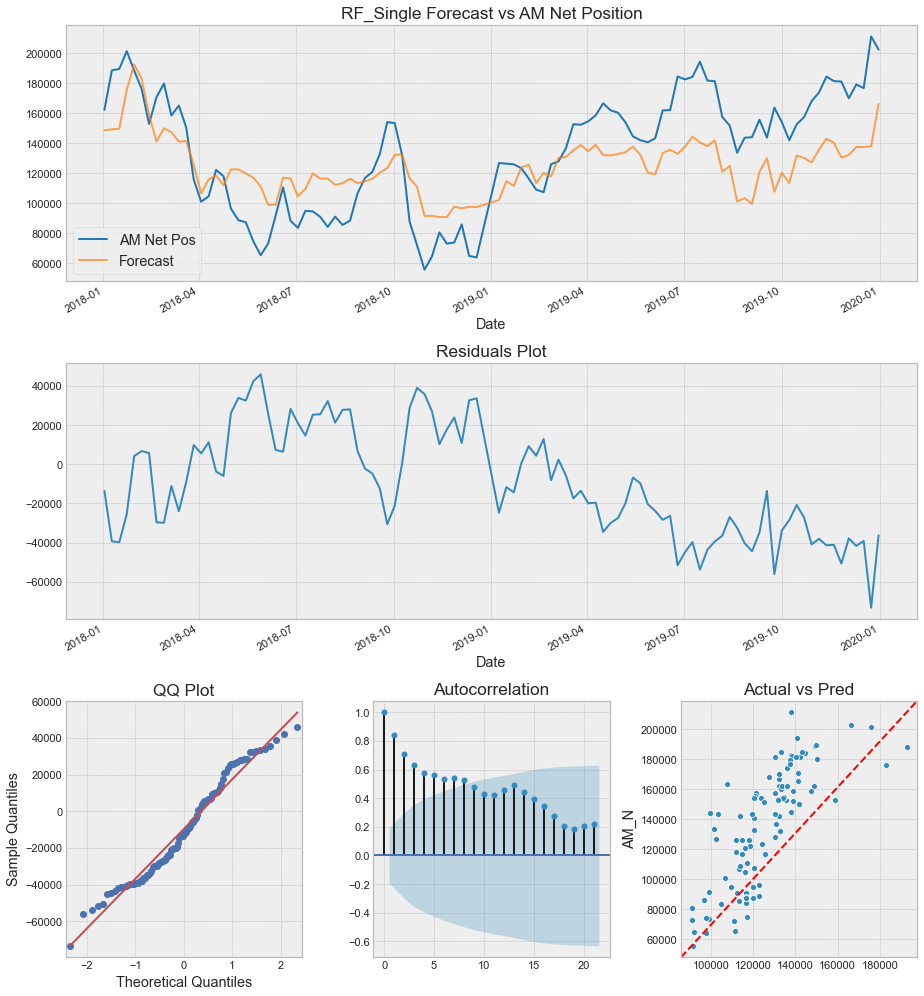

In [47]:
evaluate('RF_Single', y_test, pd.Series(forecast, index = y_test.index))

In [ ]:
y_pred = rf.predict(X_test_std)
tsplot(y_test-y_pred,title = "Errors: Random Forest Baseline Test")

## Change in AM Position

### Data

In [4]:
df_raw=pd.read_csv('Data_Weekly_20201204.csv',index_col = "Date", parse_dates = True)
df_raw['dNetPos'] = df_raw['AM_N'].diff()


In [5]:
df_raw = df_raw.drop(df_raw.index[0])
df_raw = df_raw.drop('AM_N', axis = 1)
col_name='dNetPos'
first_col = df_raw.pop(col_name)
df_raw.insert(0, col_name, first_col)

df_raw.head()

dNetPos  FedFund  ON_IndSwp  LIBOR_3  LIBOR_6  LIBOR_12  T10Y3M  \
Date                                                                          
2010-06-29 -17663.0     0.15     0.2915  0.53300  0.75069   1.17438    2.82   
2010-07-06  -1699.0     0.18     0.2850  0.53113  0.74244   1.16313    2.78   
2010-07-13  23534.0     0.17     0.2760  0.52594  0.73313   1.14500    3.00   
2010-07-20  -4359.0     0.18     0.2490  0.51250  0.71088   1.10188    2.82   
2010-07-27   -346.0     0.19     0.2650  0.48125  0.69431   1.07469    2.93   

            T10Y2Y  T10YIE  ret_USD_TWFX  ...  lag_AM_Briese_Index  \
Date                                      ...                        
2010-06-29    2.36    1.83      0.009476  ...                  NaN   
2010-07-06    2.33    1.69     -0.009447  ...                  NaN   
2010-07-13    2.48    1.87     -0.007572  ...                  NaN   
2010-07-20    2.37    1.70      0.001680  ...                  NaN   
2010-07-27    2.43    1.82     -0.008256  ...                  NaN   

            lag_HF_Briese_Index  lag_ALL_Briese_Index  lag_AM_Move  \
Date                                                                 
2010-06-29                  NaN                   NaN          NaN   
2010-07-06                  NaN                   NaN          NaN   
2010-07-13                  NaN                   NaN          NaN   
2010-07-20                  NaN                   NaN          NaN   
2010-07-27                  NaN                   NaN          NaN   

            lag_HF_Move  lag_All_Move  lag_AM_L_Conc  lag_AM_S_Conc  \
Date                                                                  
2010-06-29          NaN           NaN            NaN            NaN   
2010-07-06          NaN           NaN            NaN            NaN   
2010-07-13          NaN           NaN            NaN            NaN   
2010-07-20          NaN           NaN            NaN            NaN   
2010-07-27          NaN           NaN            NaN            NaN   

            lag_HF_L_Conc  lag_HF_S_Conc  
Date                                      
2010-06-29            NaN            NaN  
2010-07-06            NaN            NaN  
2010-07-13            NaN            NaN  
2010-07-20            NaN            NaN  
2010-07-27            NaN            NaN  

[5 rows x 61 columns]

### EDA: Response

In [8]:
#Drop price columns
cols = ['XAU','JNK', 'SPX Index','W5000', 'NASDAQ', 'USD_TWFX', 'USD_BrettFX', 'EUR',  'JPY','JNK_Volm']
df = df_raw.drop(columns = cols)

#add 2020 to a df
df_insane = df.iloc[-48:,:]

#remove 2020 from the sample, but keep NA vals for now
df_preCOV = df.iloc[:-48,:]

#Now remove NA's before passing to training.  Train and test end up w/ different shapes if you don't drop before this.
df_trimmed = df_preCOV.dropna(axis = 1)

#train period 6/22/10 - 12/26/17; test 1/2/2018 - 12/31/2019
df_train = df_trimmed.iloc[:390,:]
df_test = df_trimmed.iloc[390:,:]


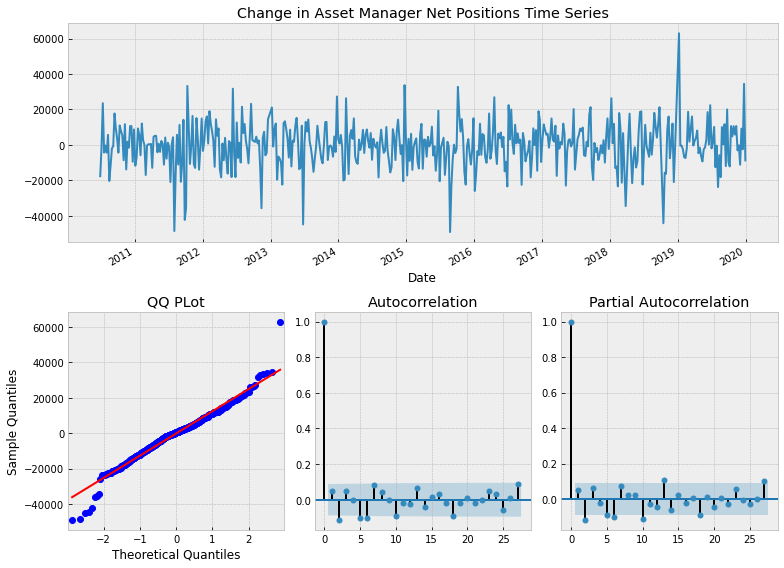

In [6]:
tsplot1(df_preCOV['dNetPos'],title = 'Change in Asset Manager Net Positions Time Series')

In [7]:
res = sm.tsa.arma_order_select_ic(df['dNetPos'], ic=['aic', 'bic'], trend = 'nc')
print("AIC Order Select:",res.aic_min_order)
print("BIC Order Select:",res.bic_min_order)

AIC Order Select: (4, 2)
BIC Order Select: (0, 1)


In [53]:
res = adfuller(df_preCOV['dNetPos'])
print("ADF",res)

ADF (-6.375196542001554, 2.2929558854773444e-08, 13, 478, {'1%': -3.4441047380903007, '5%': -2.867605550172837, '10%': -2.570000704119326}, 10264.65120388795)


#### Predictor / Response Correlations for Diff

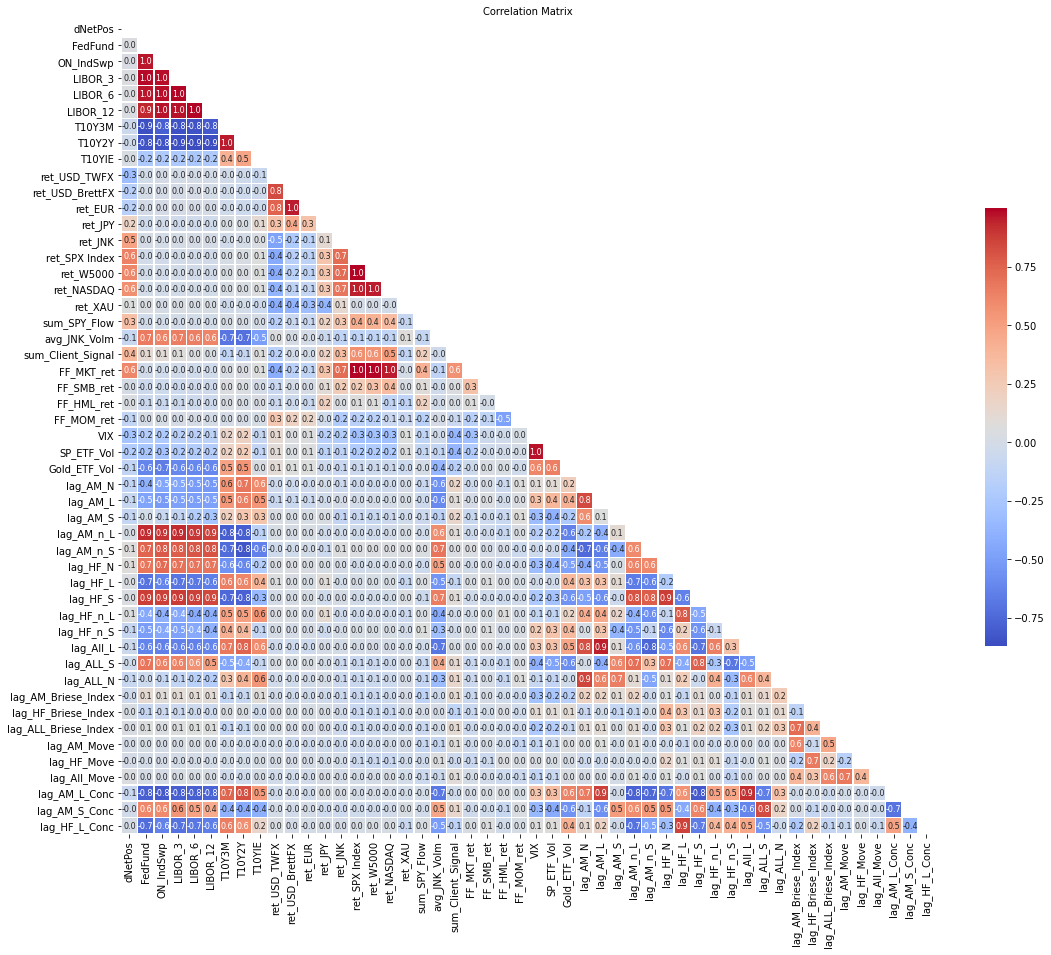

In [8]:
plotCorr(df_preCOV,save=False)

In [54]:
df_preCOV['year'] = df_preCOV.index.year
y_train = df_preCOV['dNetPos']

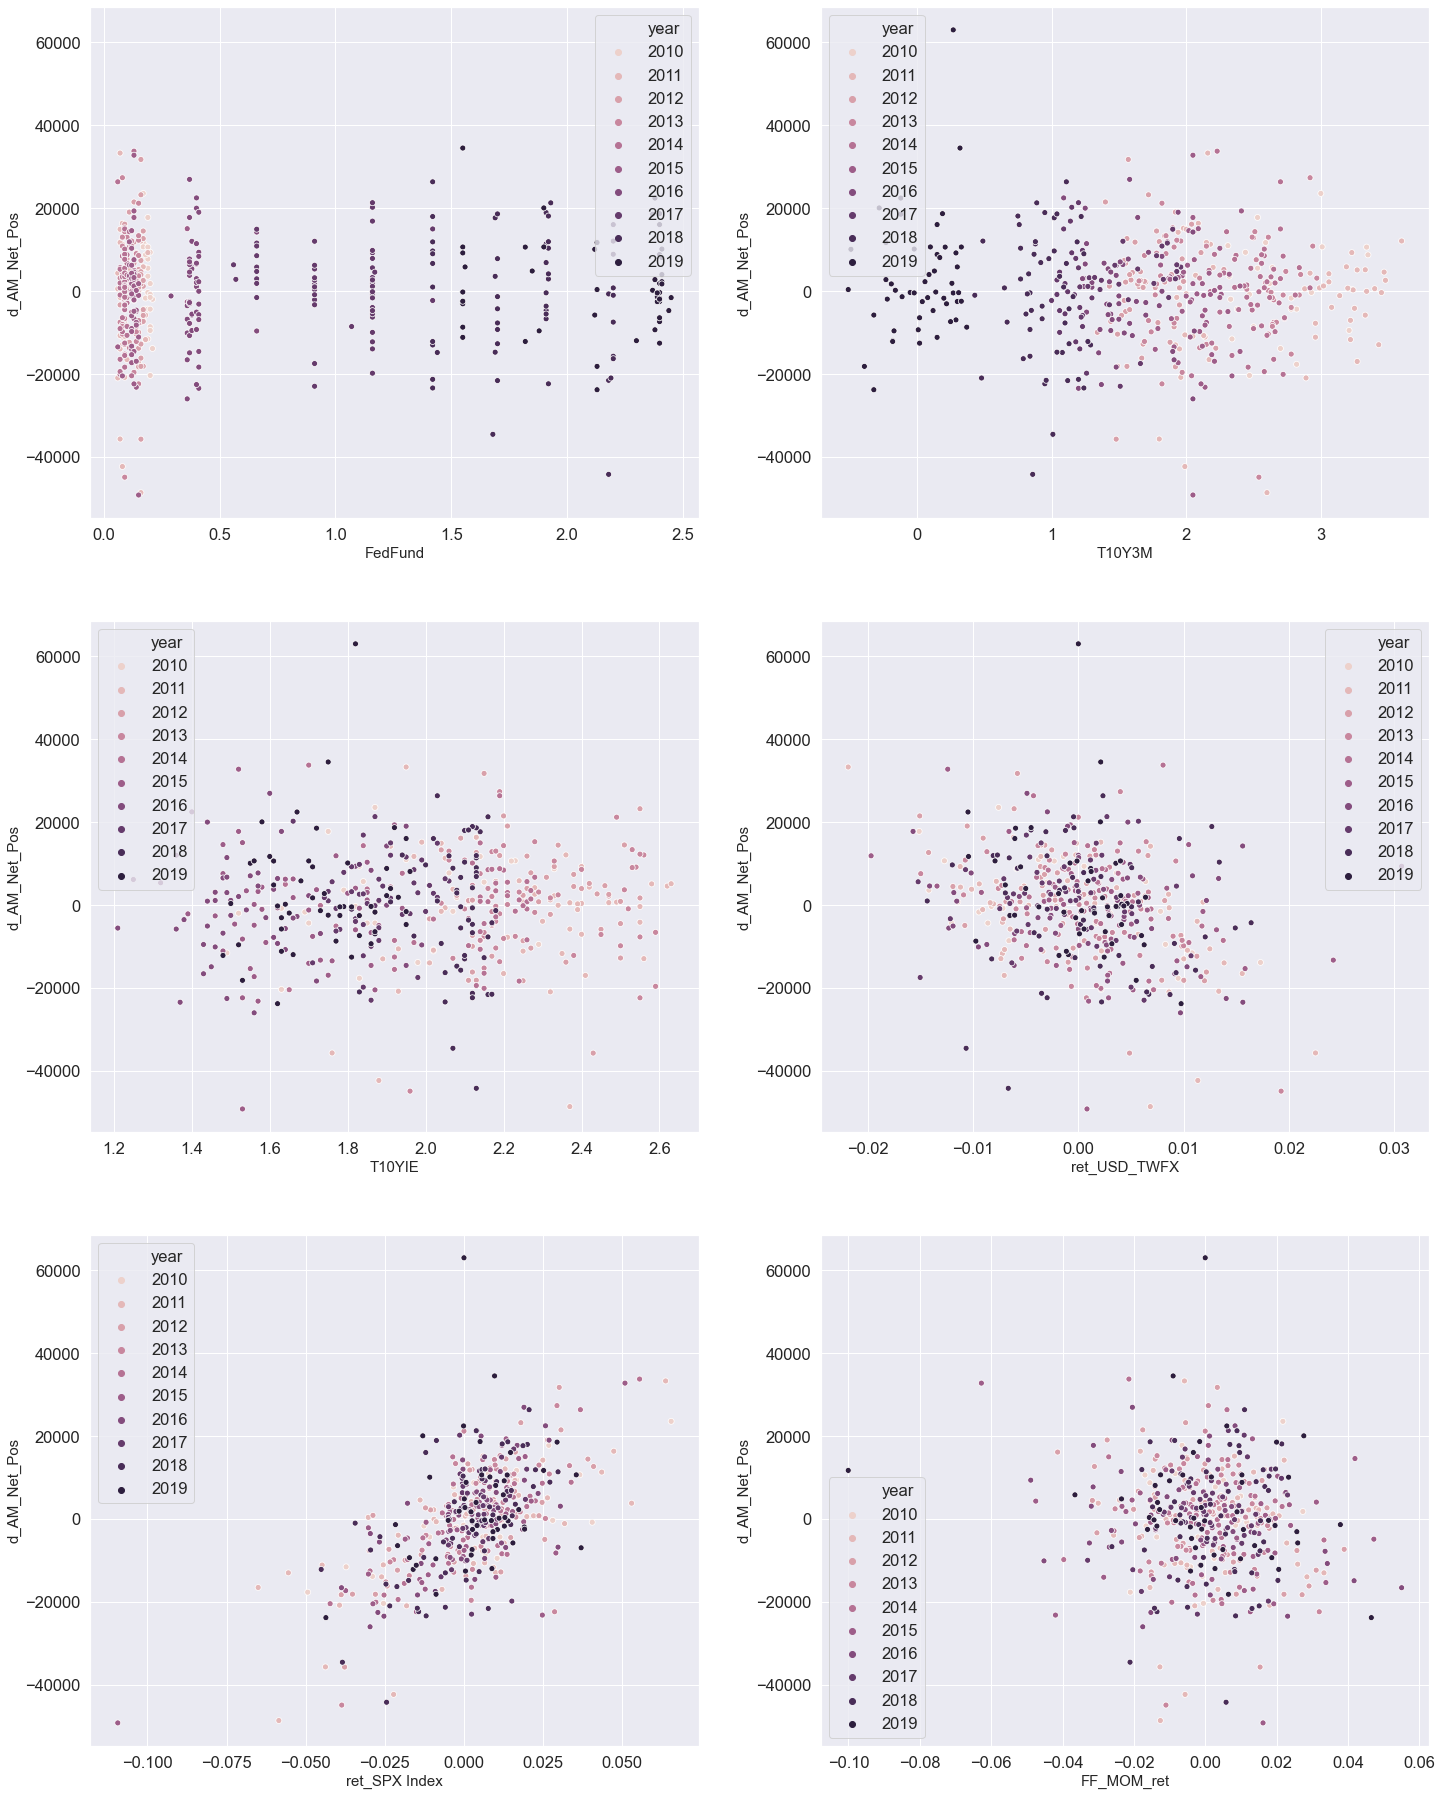

In [55]:
#look at one of each Asset Type Across Time
fig = plt.figure(figsize = (24,32))
sns.set(font_scale = 1.5)
axs = fig.subplots(3,2)
picklst = ['FedFund','T10Y3M','T10YIE','ret_USD_TWFX','ret_SPX Index','FF_MOM_ret','sum_SPY_Flow','avg_JNK_Volm']
for i in range(6):
    sns.scatterplot(x=df_preCOV.loc[:,picklst[i]], y=y_train, data=df_preCOV, hue="year",legend="full", ax=axs[i//2,i%2])
    axs[i//2, i%2].set_ylabel("d_AM_Net_Pos", fontsize = 15)
    axs[i//2, i%2].set_xlabel(picklst[i], fontsize = 15)

In [56]:
df_preCOV['year'] = df_preCOV.index.year
y_train = df_preCOV['dNetPos']

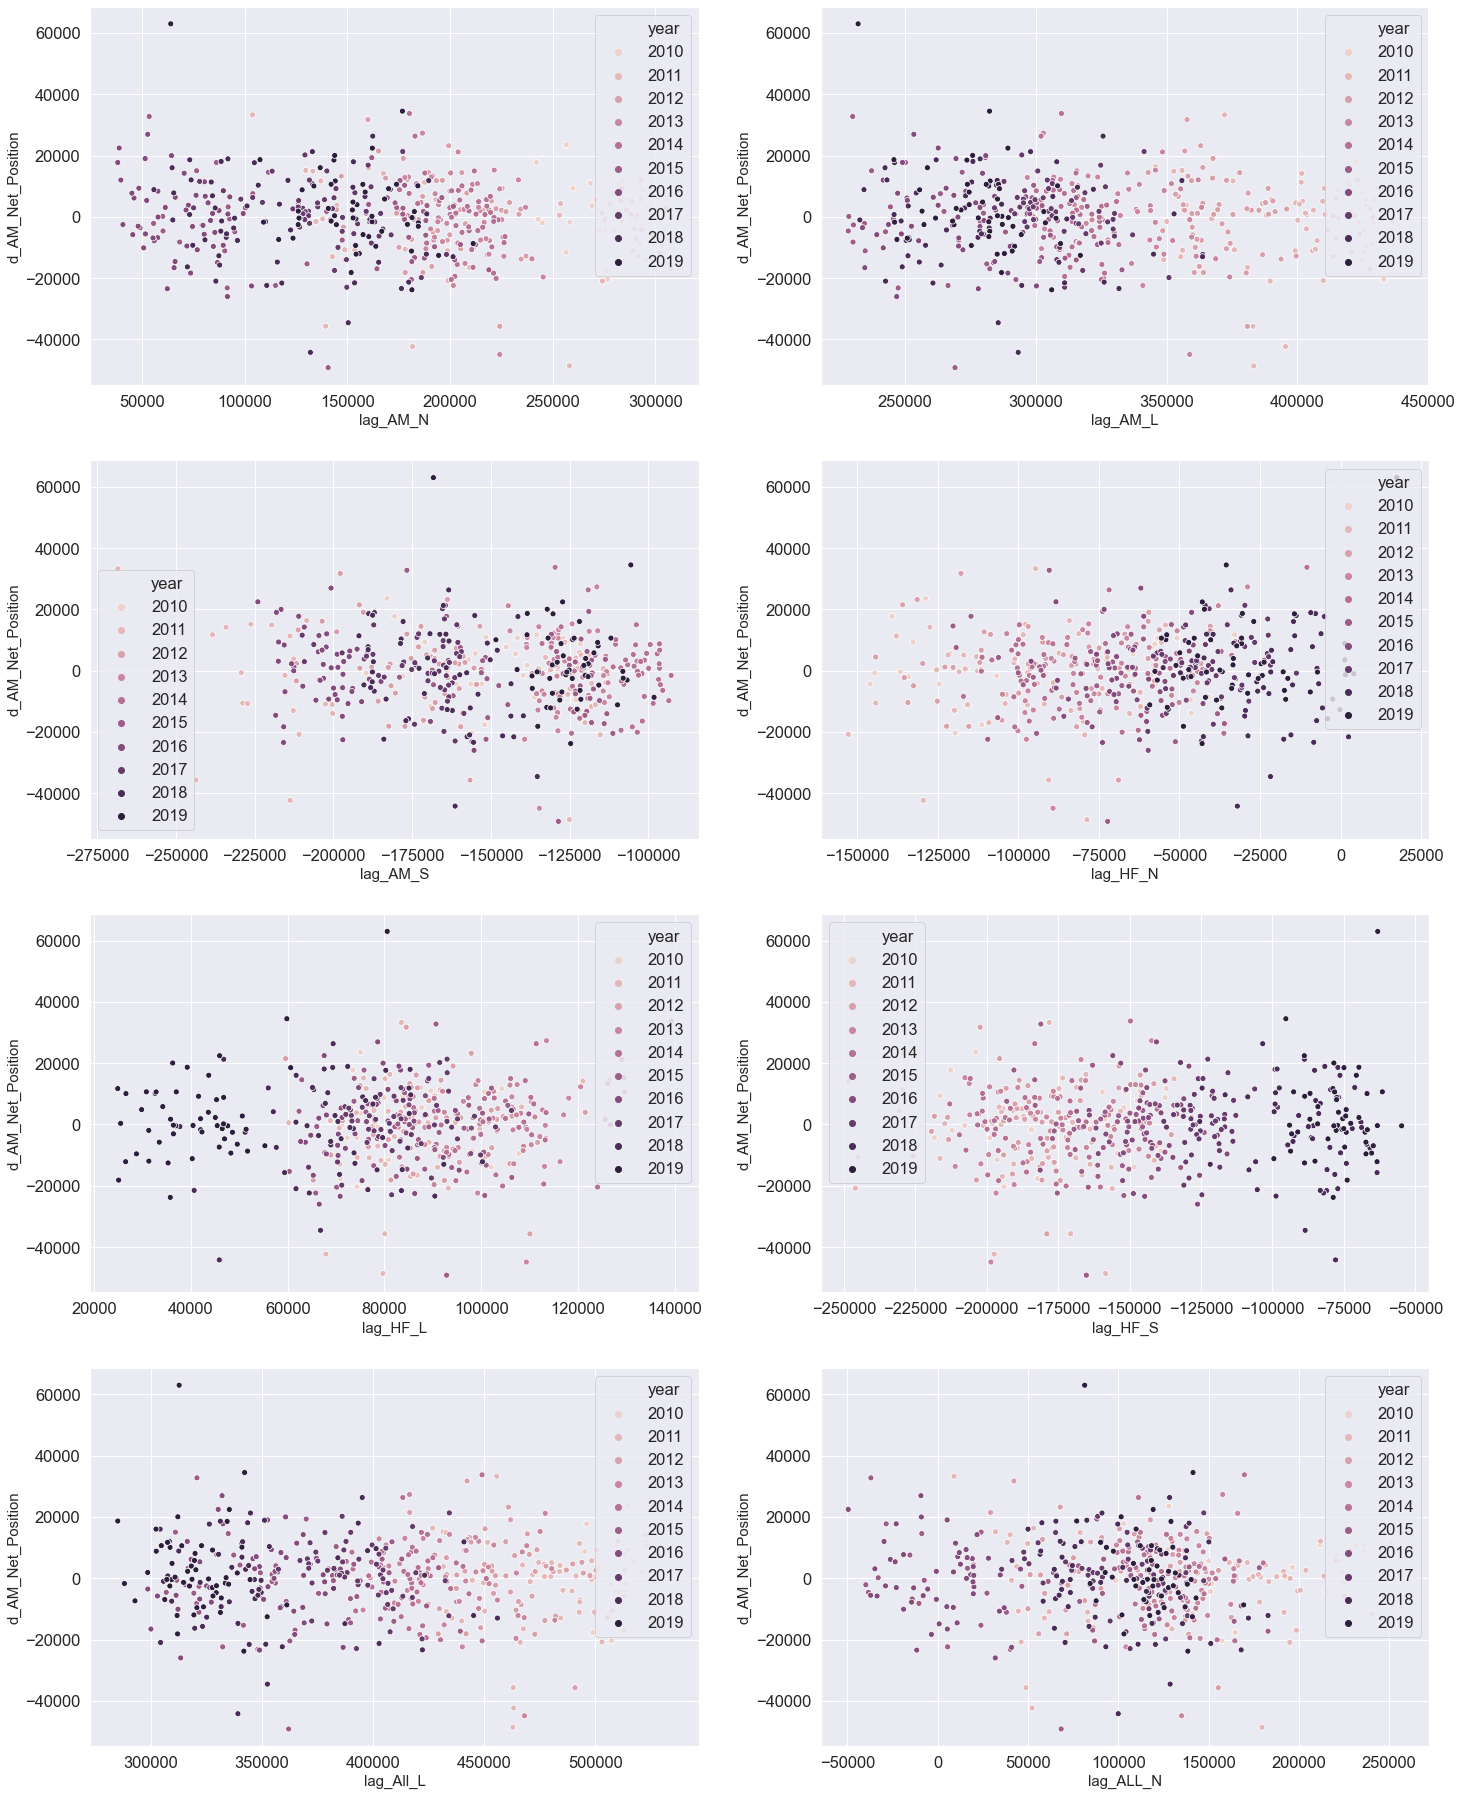

In [57]:
fig = plt.figure(figsize = (24,32))
sns.set(font_scale = 1.5)
axs = fig.subplots(4,2)
picklst = ['lag_AM_N','lag_AM_L', 'lag_AM_S', 'lag_HF_N', 'lag_HF_L', 'lag_HF_S', 'lag_All_L', 'lag_ALL_N']
for i in range(8):
    sns.scatterplot(x=df_preCOV.loc[:,picklst[i]], y=y_train, data=df_preCOV, hue="year",legend="full", ax=axs[i//2,i%2])
    axs[i//2, i%2].set_ylabel("d_AM_Net_Position", fontsize = 15)
    axs[i//2, i%2].set_xlabel(picklst[i], fontsize = 15)

In [58]:
df_preCOV = df_preCOV.drop(columns = ['year'])


#### Lasso 

In [59]:
pred, MSE, MAE, APE, var_sel, y_true, idx = Rolling('Lasso',122,5)


Model: Lasso
MSE is 109.99
MAE is 7617.58
APE is 0.07


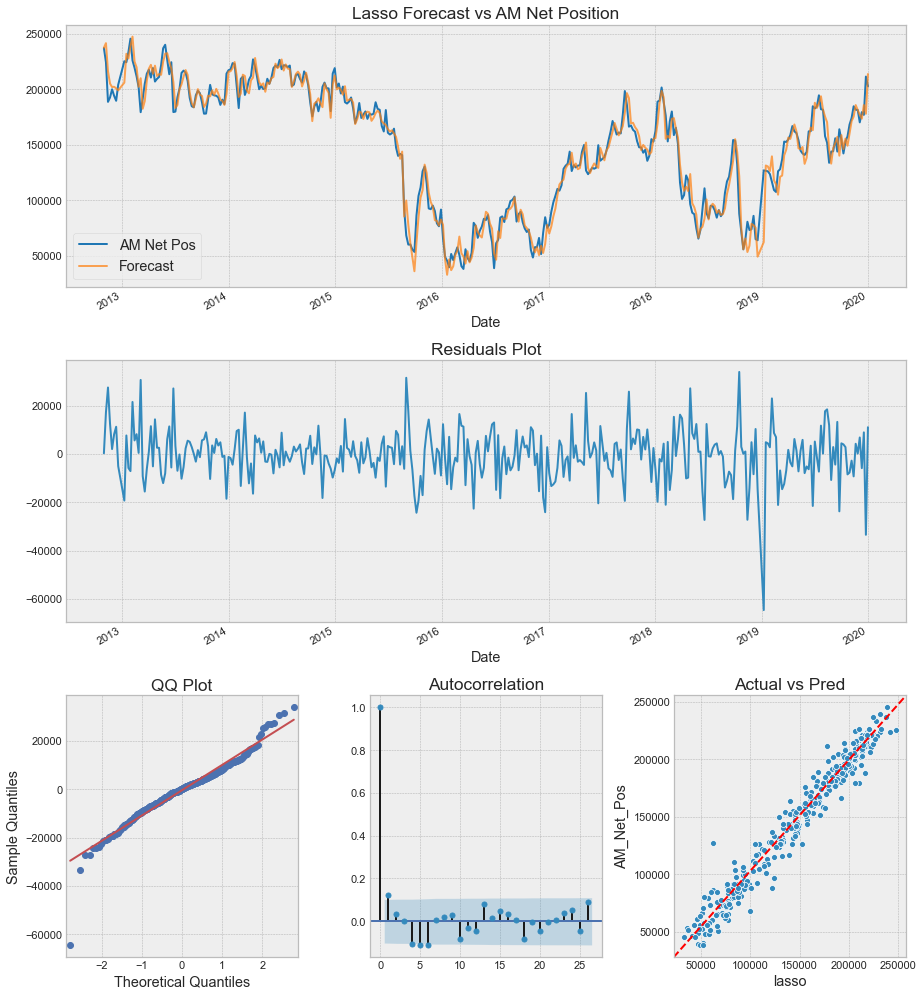

In [68]:
y, y_hat = AddBack('lasso',y_true, pred)
evaluate('Lasso',y, y_hat)

In [69]:
ErrorTest(y,y_hat)

    lb_stat  lb_pvalue
1  5.484532   0.019185
2  5.883340   0.052778
3  5.887483   0.117215 

AIC Order Select: (4, 2)
BIC Order Select: (1, 0)


#### Ridge

In [70]:
pred, MSE, MAE, APE, var_sel, y_true, idx = Rolling('Ridge',122,5)

Model: Ridge
MSE is 166.31
MAE is 9665.71
APE is 0.08


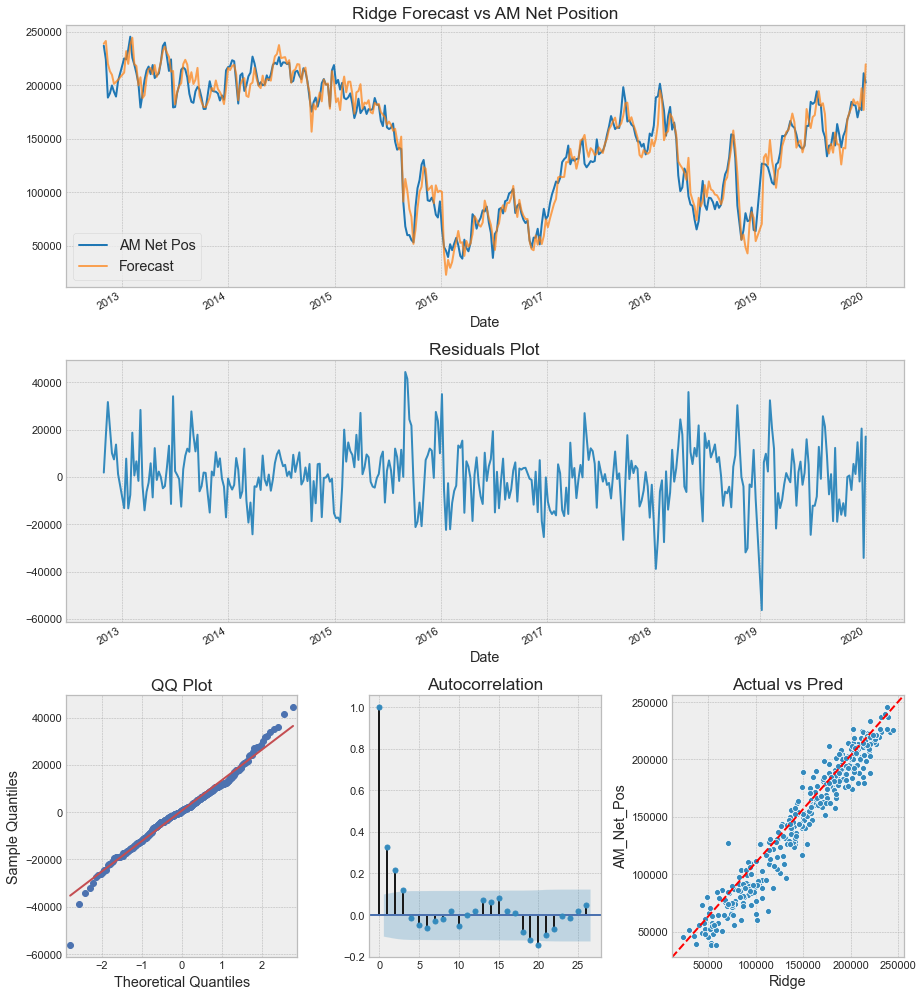

In [71]:
y, y_hat = AddBack('Ridge',y_true, pred)
evaluate('Ridge',y, y_hat)

In [72]:
ErrorTest(y,y_hat)

     lb_stat     lb_pvalue
1  40.272010  2.209520e-10
2  57.773879  2.848142e-13
3  63.037012  1.318734e-13 

AIC Order Select: (2, 0)
BIC Order Select: (1, 0)


#### Eslastic Net

In [73]:
pred, MSE, MAE, APE, var_sel, y_true, idx = Rolling('ElasticNet',122,5)

Model: ElasticNet
MSE is 106.29
MAE is 7523.74
APE is 0.06


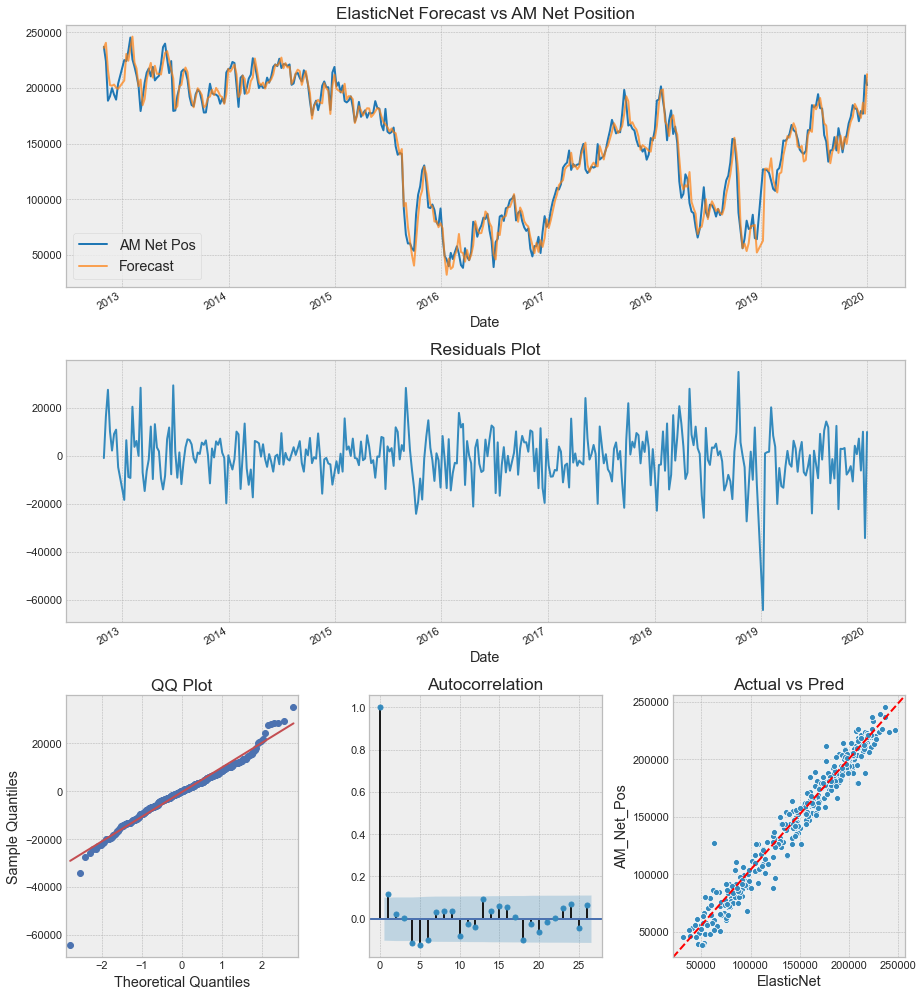

In [74]:
y, y_hat = AddBack('ElasticNet',y_true, pred)
evaluate('ElasticNet',y, y_hat)

In [75]:
ErrorTest(y,y_hat)

    lb_stat  lb_pvalue
1  5.085640   0.024125
2  5.243605   0.072672
3  5.250954   0.154317 

AIC Order Select: (4, 2)
BIC Order Select: (1, 0)


#### SVR

In [81]:
pred, MSE, MAE, APE, var_sel, y_true, idx = Rolling('SVReg',122,5)

Model: SVR
MSE is 144.11
MAE is 8747.11
APE is 0.07


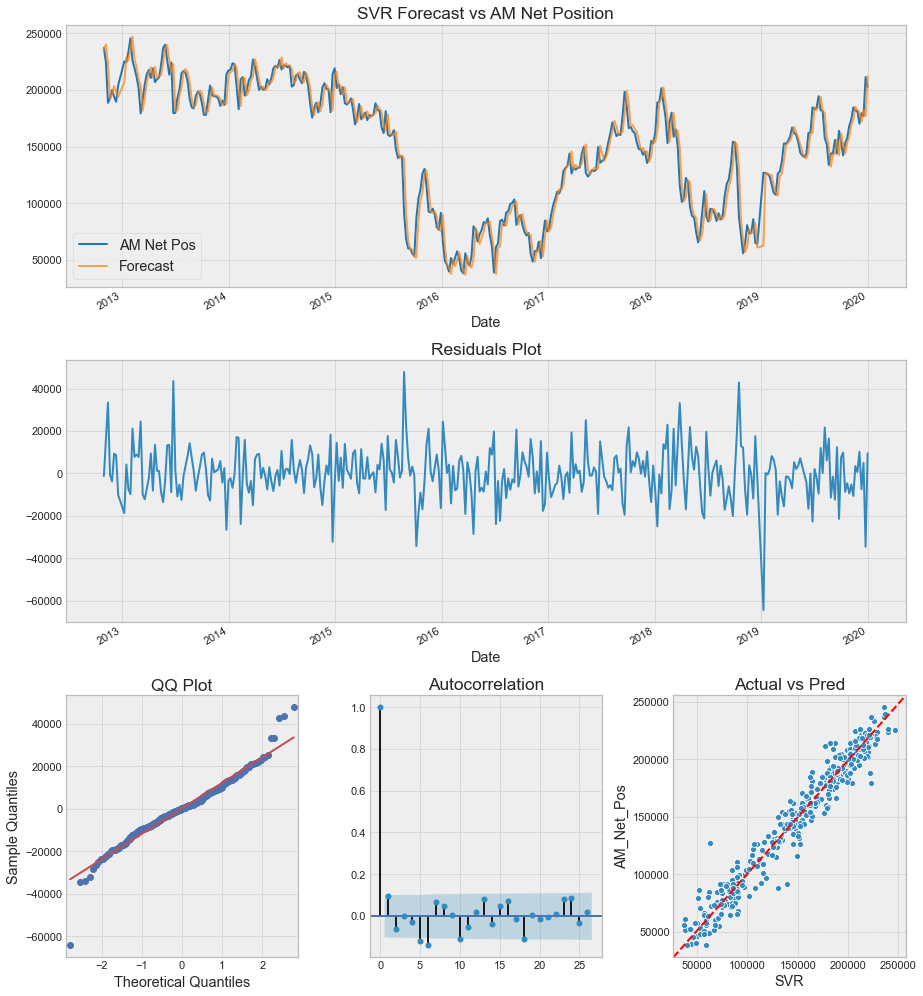

In [82]:
y, y_hat = AddBack('SVR',y_true, pred)
evaluate('SVR',y, y_hat)

In [83]:
ErrorTest(y,y_hat)

    lb_stat  lb_pvalue
1  3.475273   0.062292
2  4.874061   0.087420
3  4.876785   0.181045 

AIC Order Select: (1, 1)
BIC Order Select: (1, 1)


#### Random Forest

In [84]:
pred, MSE, MAE, APE, var_sel, y_true, idx = Expanding('RF',222,10)

Model: RF
MSE is 130.28
MAE is 8166.73
APE is 0.08


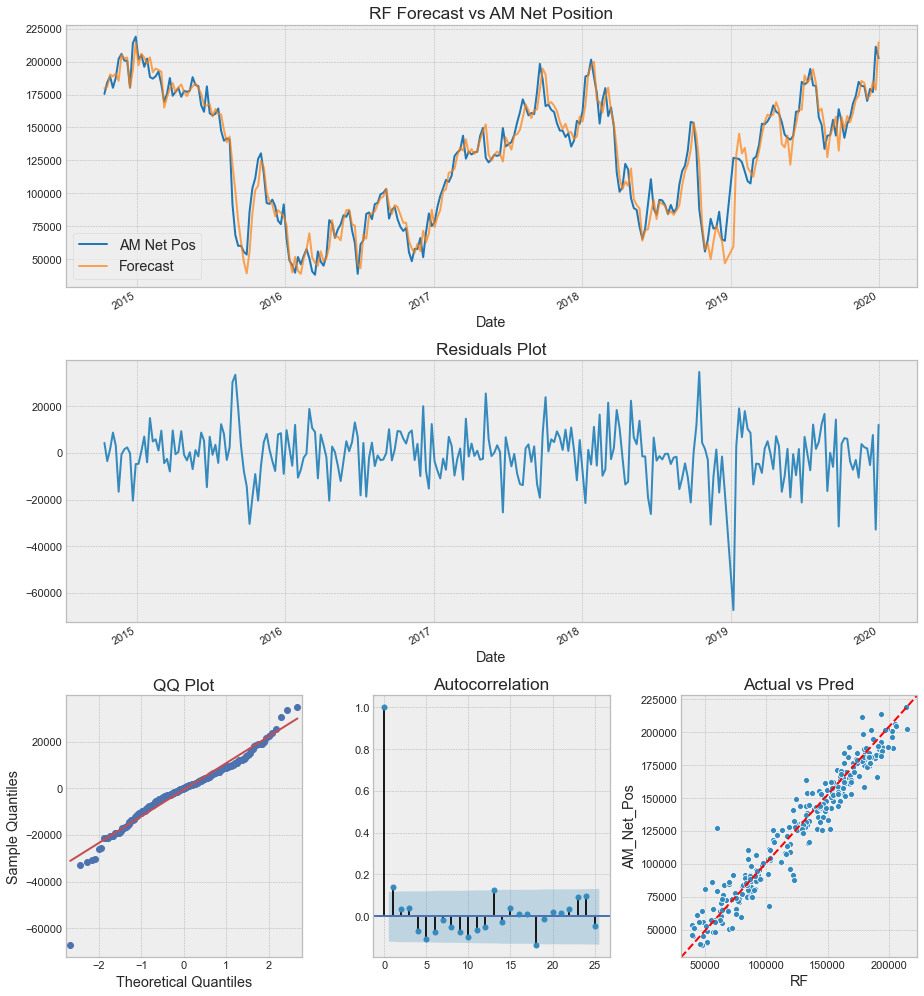

In [85]:
y, y_hat = AddBack('RF',y_true, pred)
evaluate('RF',y, y_hat)

In [86]:
ErrorTest(y,y_hat)

    lb_stat  lb_pvalue
1  5.443670   0.019639
2  5.811841   0.054698
3  6.229586   0.100959 

AIC Order Select: (3, 2)
BIC Order Select: (1, 0)


#### Variable Selection with Random Forest and Lasso

In [156]:
tscv = TimeSeriesSplit(n_splits = 5)
X_train = df_train.iloc[:,1:]
y_train = df_train.iloc[:,0]
X_test = df_test.iloc[:,1:]
y_test = df_test.iloc[:,0]

#standardize our predictors (std 1, mean 0)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

feat_importance, forecast = RF(X_train_std, X_test_std, X_train, y_train,tscv)

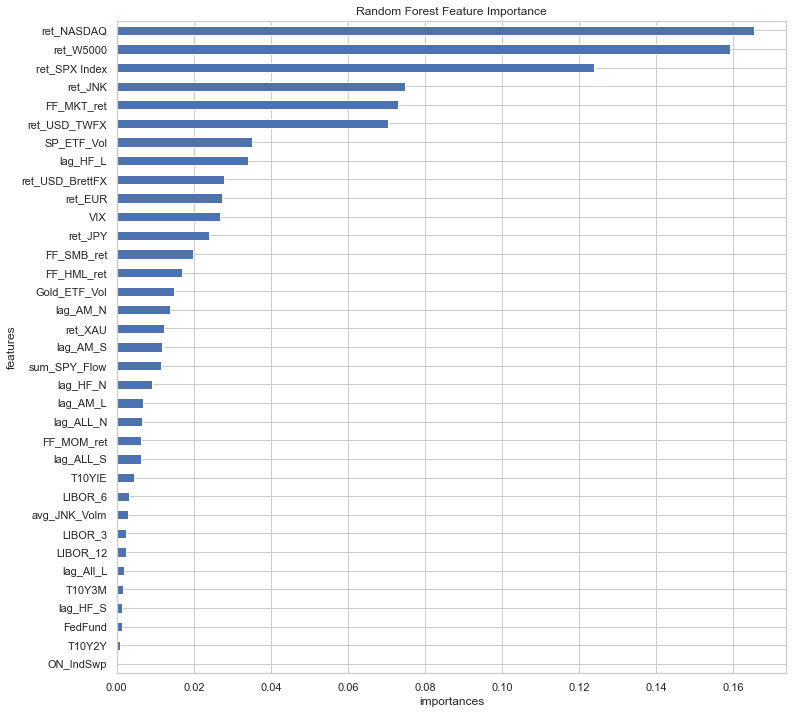

In [157]:
fis = np.argsort(feat_importance)
feat_importance = feat_importance[fis]
fig = plt.figure(figsize = [12,12])
ax = fig.subplots(1,1)
feat_importance.plot(kind = 'barh', ax = ax)
plt.ylabel('features')
plt.xlabel('importances')
plt.title("Random Forest Feature Importance")
plt.show()

In [158]:
rf_pick = feat_importance[-10:].index

In [159]:
lasso = LassoCV(max_iter = 100000, cv = tscv)
lasso.fit(X_train_std, y_train)
alpha_range = lasso.alphas_
mse_values = lasso.mse_path_.mean(axis = 1)
sd_values = lasso.mse_path_.std(axis = 1)
alpha_min_ind = np.where(np.abs(np.log(alpha_range) - np.log(lasso.alpha_)) < 1e-4)[0]
alpha_1se_ind = len(mse_values) - np.searchsorted(mse_values[::-1], mse_values[alpha_min_ind]+sd_values[alpha_min_ind])
alpha_1se = alpha_range[alpha_1se_ind]

# 1se
from sklearn.linear_model import Lasso
lasso_1se = Lasso(alpha = alpha_1se, max_iter = 10000)
lasso_1se.fit(X_train_std, y_train)

Lasso(alpha=array([4641.1318826]), max_iter=10000)

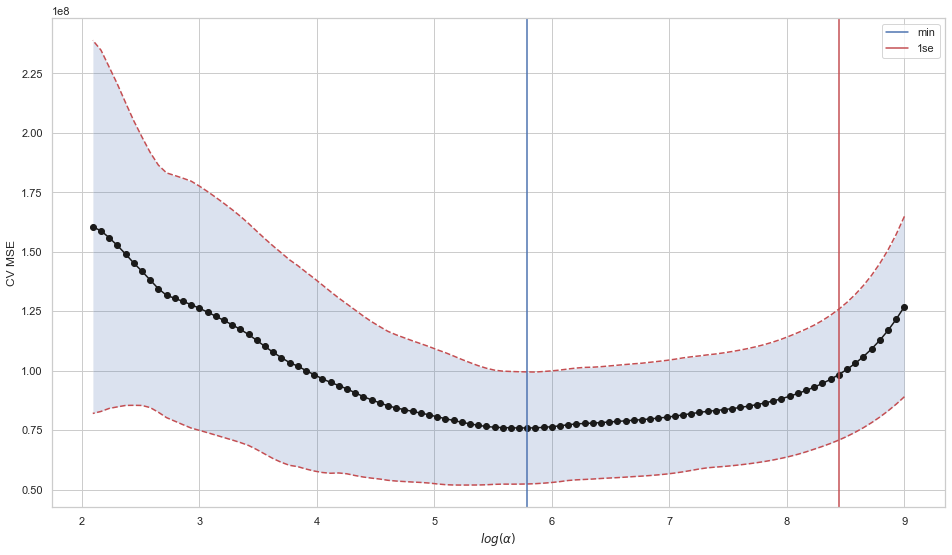

In [160]:
plt.figure(figsize = [16,9])
sns.set_style("whitegrid")
plt.plot(np.log(alpha_range), mse_values ,"ko-")
plt.plot(np.log(alpha_range), mse_values + sd_values,"r--")
plt.plot(np.log(alpha_range), mse_values - sd_values,"r--")
plt.fill_between(np.log(alpha_range),
                mse_values + sd_values,
                mse_values - sd_values, alpha = .2)

plt.axvline(np.log(lasso.alpha_), label = 'min')
plt.axvline(np.log(alpha_1se), label = '1se', color = 'r')
plt.legend()
plt.xlabel(r"$log(\alpha)$")
plt.ylabel("CV MSE");

In [161]:
lasso_pick = X_train.columns[np.abs(lasso.coef_ - 0) > 1e-4]
lasso_pick

Index(['ret_EUR', 'ret_JNK', 'ret_SPX Index', 'ret_XAU', 'sum_SPY_Flow',
       'avg_JNK_Volm', 'FF_SMB_ret', 'VIX', 'Gold_ETF_Vol', 'lag_AM_N',
       'lag_AM_S', 'lag_HF_N', 'lag_HF_L'],
      dtype='object')

In [162]:
X_train.columns[np.abs(lasso_1se.coef_ - 0) > 1e-4]

Index(['ret_SPX Index'], dtype='object')

In [163]:
common_pick = set(rf_pick).intersection(set(lasso_pick))
cols = list(common_pick)


['lag_HF_L', 'ret_SPX Index', 'ret_JNK', 'ret_EUR']

In [23]:
cols = ['dNetPos','ret_EUR', 'ret_SPX Index', 'sum_SPY_Flow', 'VIX']

In [24]:
df_train_sel= df_train.reindex(cols,axis="columns")   
df_test_sel=df_test.reindex(cols,axis="columns")   
X_train_sel = df_train_sel.iloc[:,1:]
y_train = df_train_sel.iloc[:,0]
X_test_sel = df_test_sel.iloc[:,1:]
y_test = df_test_sel.iloc[:,0]
tscv = TimeSeriesSplit(n_splits = 5)

#### Gradient Boosting

In [28]:
p_test = {'min_samples_split':[20,50,80],'max_depth':[2,4,6,8],'n_estimators':[20,30,50]}
clf = GridSearchCV(GradientBoostingRegressor(), param_grid = p_test, cv = tscv,scoring='neg_mean_absolute_error')
clf.fit(X_train_sel, y_train)
clf.best_params_



{'max_depth': 2, 'min_samples_split': 20, 'n_estimators': 30}

In [29]:
params = {'n_estimators': 30, 'max_depth': 2, 'min_samples_split': 20,
      'learning_rate': .05}
clf = GradientBoostingRegressor(**params).fit(X_train_sel, y_train)
forecast = clf.predict(X_test_sel)


In [30]:
forecast = pd.Series(forecast, index = y_test.index)


Model: Grad Boost
MSE is 15644.82
MAE is 9000.67
APE is 0.07


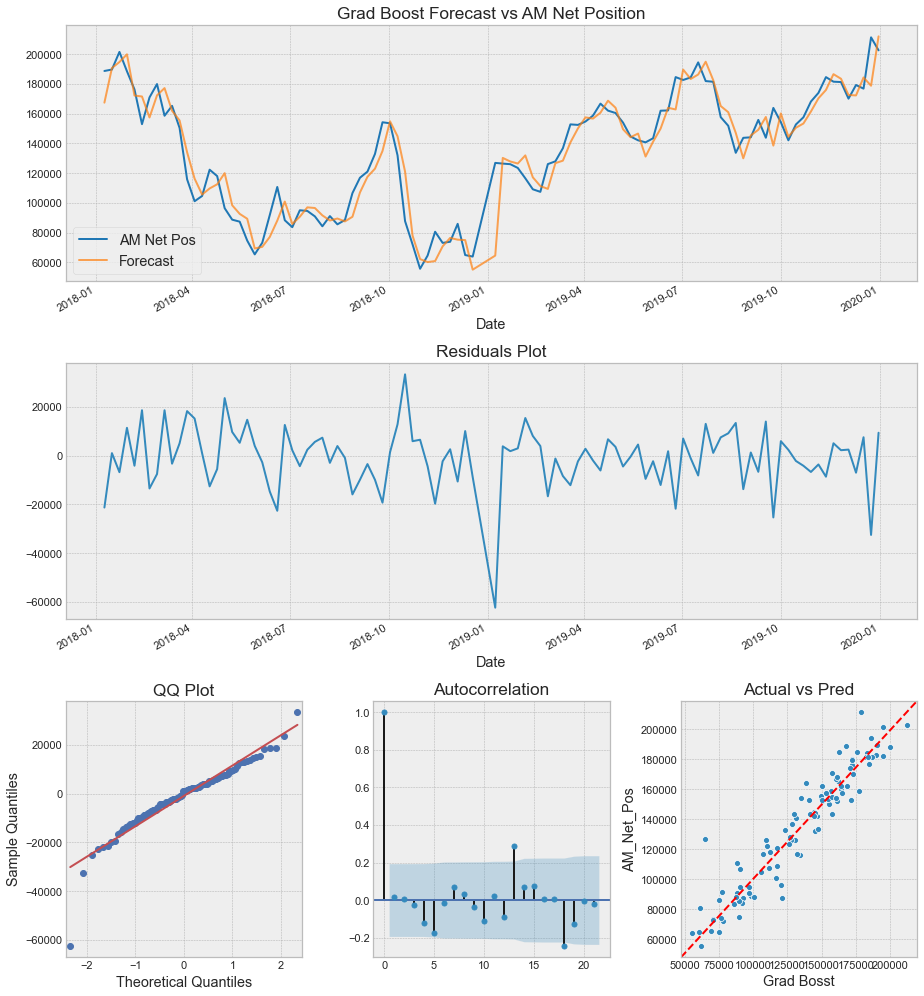

In [35]:
y, y_hat = AddBack('Grad Bosst',y_test, forecast)
evaluate('Grad Boost',y, y_hat,'dif')